In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import re

In [2]:
## Input/Output
# DATA_FOLDER = "C:\\Users\\E2884\\Desktop\\WPy64-3980\\notebooks\\data\\SPC\\"
DATA_FOLDER = "data/SPC/"
FILE = "SPC_FOOD_SECURITY.csv"

In [3]:
df_raw = pd.read_csv(DATA_FOLDER + FILE)
#print(df_raw.head())

In [4]:
# Export dans excel
# df_net.to_excel(DATA_FOLDER + "SPC_FOOD_SECURITY.xlsx")

In [5]:
HEADER = list(df_raw.columns)
# print(len(df_raw.index), len(df_raw.columns.to_list()), df_raw.columns.to_list())
# for el in HEADER[10:]:
#     print(el)
#     print(df_raw[el].unique())

df_net = df_raw.drop(columns=['DATAFLOW', 'FREQ: Frequency','UNIT_MULT: Unit multiplier',\
                              'OBS_STATUS: Observation Status','DATA_SOURCE: Data source',\
                             'OBS_COMMENT: Comment','CONF_STATUS: Confidentiality status'])

# HEADER = list(df_net.columns)
# for el in HEADER:
#     print(el)
#     print(df_net[el].unique())

In [6]:
df_net = df_net.rename(columns={'TIME_PERIOD: Time': 'YEAR', 
                                'GEO_PICT: Pacific Island Countries and territories': 'REGION',
                                'INDICATOR: Indicator':'INDICATEUR',
                                'SEX: Sex':'GENRE',
                                'AGE: Age':'AGE',
                                'URBANIZATION: Urbanization':'URBANISATION',
                                'POVERTY: Poverty':'POVERTY',
                                'FOOD_SECURITY: Food security':'FOOD_SECURITY',
                                'FOOD: Food category':'FOOD_CATEGORY',
                                'OBS_VALUE':'VALUE',
                                'UNIT_MEASURE: Unit of measure':'UNIT'
                               })
# print(df_net.columns)
# print(df_net)

# Correction de la devise
dict_DEVISE = {'KI': 72.33,'SB': 13.36 ,'VU': 0.91502}

new_column = []
for reg in df_net['REGION']:
    new_column.append(re.findall("(\w\w).*", reg)[0])
df_net['PAYS'] =  new_column

df_net['PRIX_$'] = df_net['VALUE']*df_net['PAYS'].map(dict_DEVISE)
print(df_net['INDICATEUR'].unique())

['CONSGTAVG: Percentage of households who consumed more than the average number of products consumed in the group'
 'AQAA: Average quantity as acquired' 'AVGEQ: Average edible quantity'
 'AVGDEC: Average Dietary Energy Consumption'
 'AVGEXP: Average expenditures'
 'CONSAL1: Percentage of HH who consumed at least one product of the group'
 'CONSLTAVG: Percentage of households who consumed less than the average number of products consumed in the group'
 'AVGNPRDCONS: Average number of products consumed by household by food group']


In [7]:
# Analyse n°1
pays_list = ['KI: Kiribati','SB: Solomon Islands','VU: Vanuatu']
df_pays = df_net[df_net['REGION'].isin(pays_list)]
df_pays_total = df_pays.loc[(df_pays['GENRE'] == '_T: Total') & \
                            (df_pays['AGE'] == '_T: All ages') & \
                            (df_pays['URBANISATION'] == '_T: National') & \
                            (df_pays['POVERTY'] == '_T: Total') & \
                            (df_pays['FOOD_SECURITY'] == '_T: Total')
                           ]
df_pays_total_AVGDEC = df_pays_total[df_pays_total['INDICATEUR'] == 'AVGDEC: Average Dietary Energy Consumption']
df_gb_pays_total_AVGDEC = df_pays_total_AVGDEC.groupby(['REGION']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"kcal/capita/day"})
# print(df_gb_pays_total_AVGEQ)

df_pays_total_AVGEQ = df_pays_total[df_pays_total['INDICATEUR'] == 'AVGEQ: Average edible quantity']
df_gb_pays_total_AVGEQ = df_pays_total_AVGEQ.groupby(['REGION']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"g/capita/day"})
# print(df_gb_pays_total_AVGEQ)

df_pays_total_AVGEXP = df_pays_total[df_pays_total['INDICATEUR'] == 'AVGEXP: Average expenditures']
df_gb_pays_total_AVGEXP = df_pays_total_AVGEXP.groupby(['REGION']).agg({'PRIX_$':'sum'}).rename(columns={"PRIX_$":"XPF/capita/day"})
# print(df_gb_pays_total_AVGEXP)

df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP = pd.concat([df_gb_pays_total_AVGDEC, df_gb_pays_total_AVGEQ, df_gb_pays_total_AVGEXP], axis=1)
df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['kcal/g/capita/day']=df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['kcal/capita/day']/df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['g/capita/day']
df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['kcal/XPF/capita/day']=df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['kcal/capita/day']/df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['XPF/capita/day']
df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['g/XPF/capita/day']=df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['g/capita/day']/df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['XPF/capita/day']
print(df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP)

                     kcal/capita/day  g/capita/day  XPF/capita/day  \
REGION                                                               
KI: Kiribati                  2757.1        1210.4      253.155000   
SB: Solomon Islands           2640.6        1550.8      191.048000   
VU: Vanuatu                   2758.3        1922.1      365.824996   

                     kcal/g/capita/day  kcal/XPF/capita/day  g/XPF/capita/day  
REGION                                                                         
KI: Kiribati                  2.277842            10.890956          4.781260  
SB: Solomon Islands           1.702734            13.821657          8.117332  
VU: Vanuatu                   1.435045             7.539944          5.254152  


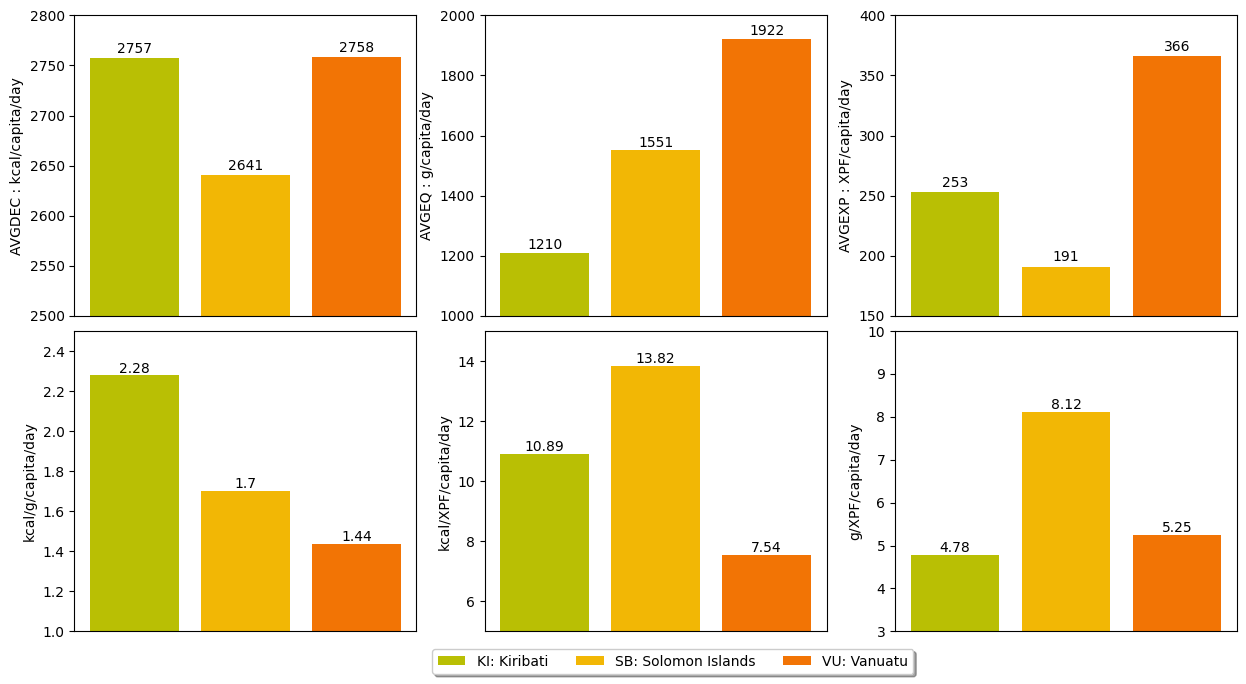

In [8]:
## GRAPHIQUE SIMPLE - 3 zone, 1 yaxis, plusieurs courbe en fonction du temps

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,8)) # Nombre et disposition des zones de dessin
fig.subplots_adjust(hspace=0.05)
plt.xticks(rotation=45)


bar_colors = ['#B9BF04', '#F2B705', '#F27405']
bar_labels = ['KI: Kiribati', 'SB: Solomon Islands', 'VU: Vanuatu']

axes[0,0].bar(df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP.index.values, df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['kcal/capita/day'], label = bar_labels, color=bar_colors)
axes[0,0].set_ylabel('AVGDEC : kcal/capita/day')
axes[0,0].set_ylim(2500,2800) 
axes[0,0].set_xticks([])

rects = axes[0,0].patches
for rect, label in zip(rects, df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['kcal/capita/day']):
    height = rect.get_height()
    axes[0,0].text(
        rect.get_x() + rect.get_width() / 2, height + 2, round(label), ha="center", va="bottom"
    )

axes[0,1].bar(df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP.index.values, df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['g/capita/day'], label = bar_labels, color=bar_colors)
axes[0,1].set_ylabel('AVGEQ : g/capita/day')
axes[0,1].set_ylim(1000,2000) 
axes[0,1].set_xticks([])

rects = axes[0,1].patches
for rect, label in zip(rects, df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['g/capita/day']):
    height = rect.get_height()
    axes[0,1].text(
        rect.get_x() + rect.get_width() / 2, height + 2, round(label), ha="center", va="bottom"
    )

axes[0,2].bar(df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP.index.values, df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['XPF/capita/day'], label = bar_labels, color=bar_colors)
axes[0,2].set_ylabel('AVGEXP : XPF/capita/day')
axes[0,2].set_ylim(150,400) 
axes[0,2].set_xticks([])

rects = axes[0,2].patches
for rect, label in zip(rects, df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['XPF/capita/day']):
    height = rect.get_height()
    axes[0,2].text(
        rect.get_x() + rect.get_width() / 2, height + 2, round(label), ha="center", va="bottom"
    )

####################
axes[1,0].bar(df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP.index.values, df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['kcal/g/capita/day'], label = bar_labels, color=bar_colors)
axes[1,0].set_ylabel('kcal/g/capita/day')
axes[1,0].set_ylim(1,2.5) 
axes[1,0].set_xticks([])

rects = axes[1,0].patches
for rect, label in zip(rects, df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['kcal/g/capita/day']):
    height = rect.get_height()
    axes[1,0].text(
        rect.get_x() + rect.get_width() / 2, height, round(label,2), ha="center", va="bottom"
    )

axes[1,1].bar(df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP.index.values, df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['kcal/XPF/capita/day'], label = bar_labels, color=bar_colors)
axes[1,1].set_ylabel('kcal/XPF/capita/day')
axes[1,1].set_ylim(5,15) 
axes[1,1].set_xticks([])

rects = axes[1,1].patches
for rect, label in zip(rects, df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['kcal/XPF/capita/day']):
    height = rect.get_height()
    axes[1,1].text(
        rect.get_x() + rect.get_width() / 2, height, round(label,2), ha="center", va="bottom"
    )

axes[1,2].bar(df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP.index.values, df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['g/XPF/capita/day'], label = bar_labels, color=bar_colors)
axes[1,2].set_ylabel('g/XPF/capita/day')
axes[1,2].set_ylim(3,10) 
axes[1,2].set_xticks([])

rects = axes[1,2].patches
for rect, label in zip(rects, df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['g/XPF/capita/day']):
    height = rect.get_height()
    axes[1,2].text(
        rect.get_x() + rect.get_width() / 2, height, round(label,2), ha="center", va="bottom"
    )

# Légende
axes[0,0].legend(loc="center",bbox_to_anchor=(0,0,3.5,-2.3), ncol=3, fancybox=True, shadow=True)


In [9]:
# Analyse n°2
pays_list = ['KI: Kiribati','SB: Solomon Islands','VU: Vanuatu']
df_pays = df_net[df_net['REGION'].isin(pays_list)]
df_pays_total = df_pays.loc[(df_pays['GENRE'] == '_T: Total') & \
                            (df_pays['AGE'] == '_T: All ages') & \
                            (df_pays['URBANISATION'] == '_T: National') & \
                            (df_pays['POVERTY'] == '_T: Total') & \
                            (df_pays['FOOD_SECURITY'] == '_T: Total')
                           ]
df_pays_total_AVGDEC = df_pays_total[df_pays_total['INDICATEUR'] == 'AVGDEC: Average Dietary Energy Consumption']
df_gb_pays_total_AVGDEC = df_pays_total_AVGDEC.groupby(['REGION','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"kcal/capita/day"})
df_pivot_pays_total_AVGDEC = df_gb_pays_total_AVGDEC.pivot_table(columns='REGION', index='FOOD_CATEGORY', values='kcal/capita/day')
df_pivot_pays_total_AVGDEC.loc[:,'Total'] = df_pivot_pays_total_AVGDEC.sum(numeric_only=True, axis=1)
df_pivot_pays_total_AVGDEC = df_pivot_pays_total_AVGDEC.sort_values(by=['Total'], ascending=False)
df_pivot_pays_total_AVGDEC = df_pivot_pays_total_AVGDEC.iloc[:, :].apply(lambda x: (x*100 / x.sum()))
df_pivot_pays_total_AVGDEC = df_pivot_pays_total_AVGDEC.drop('Total',axis=1)
# print(df_pivot_pays_total_AVGDEC.index)
global_order = df_pivot_pays_total_AVGDEC.index.to_list()


[Text(0, 0.5, '1: Cereals and cereal products'),
 Text(0, 1.5, '2: Roots and tubers'),
 Text(0, 2.5, '7: Fruits and fruit products'),
 Text(0, 3.5, '3: Sugars and syrups'),
 Text(0, 4.5, '13: Fish and fish products'),
 Text(0, 5.5, '6: Vegetables and vegetable products'),
 Text(0, 6.5, '19: Meals consumed away from home'),
 Text(0, 7.5, '5: Oils crops'),
 Text(0, 8.5, '11: Meat and meat products'),
 Text(0, 9.5, '15: Vegetable oils and fats'),
 Text(0, 10.5, '18: Miscellaneous and prepared foods'),
 Text(0, 11.5, '17: Non alcoholoc beverages'),
 Text(0, 12.5, '21: Tree nuts'),
 Text(0, 13.5, '20: Tobacco/kava'),
 Text(0, 14.5, '16: Oils and fats'),
 Text(0, 15.5, '14: Milk and cheese'),
 Text(0, 16.5, '10: Alcoholic beverages'),
 Text(0, 17.5, '12: Eggs'),
 Text(0, 18.5, '8: Stimulants'),
 Text(0, 19.5, '9: Spices and additive'),
 Text(0, 20.5, '4: Pulses')]

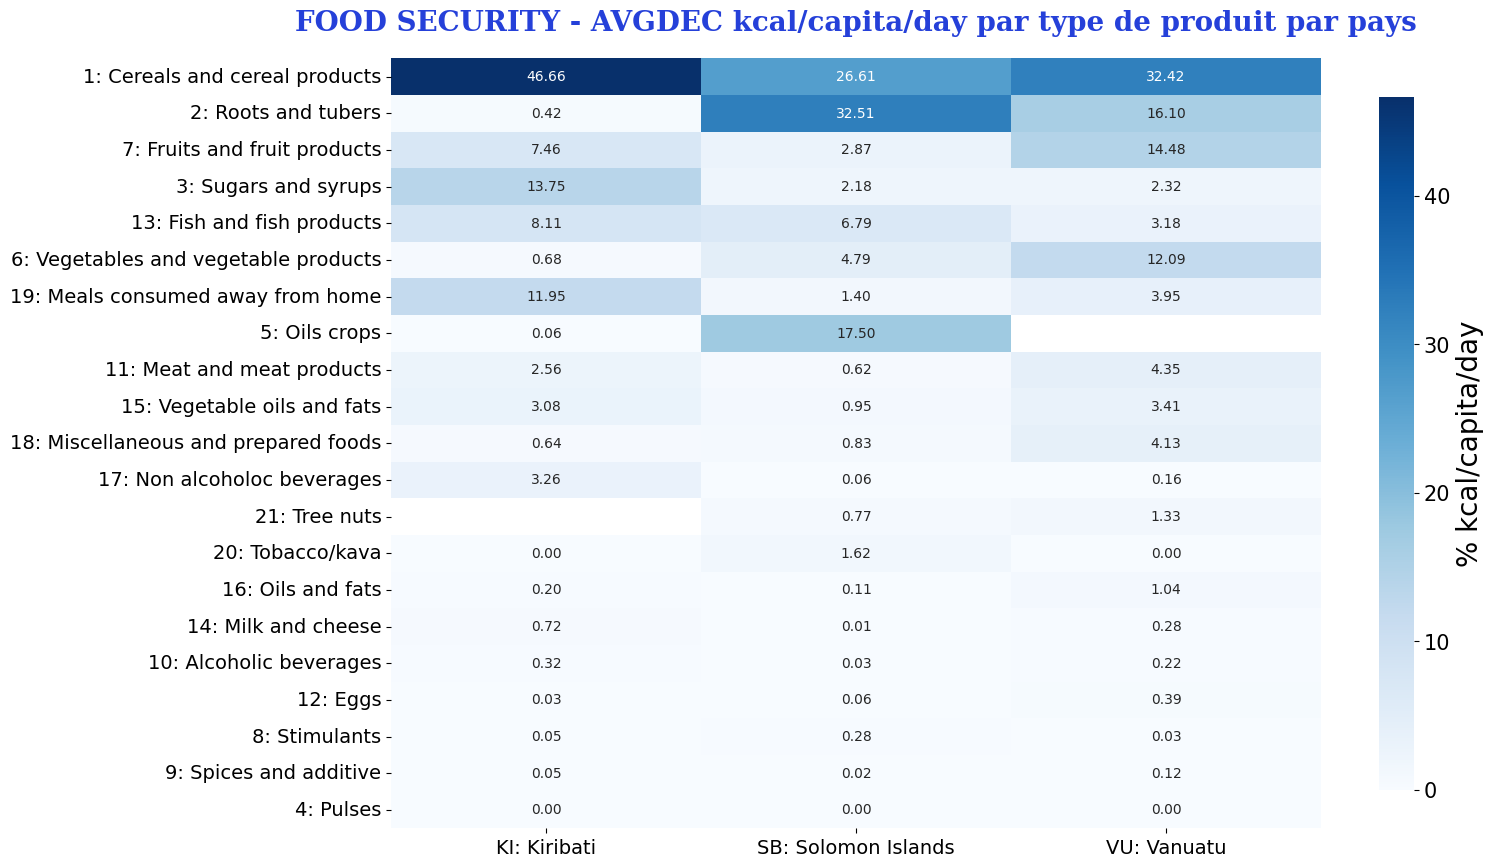

In [10]:
## GRAPHIQUE
TITLE = "FOOD SECURITY - AVGDEC kcal/capita/day par type de produit par pays"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10)) # Nombre et disposition des zones de dessin

ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 20},pad=20)
ax = sns.heatmap(df_pivot_pays_total_AVGDEC, annot=True, square=False, cmap="Blues", cbar_kws={'label': '% kcal/capita/day', 'location' : 'right',"shrink": 0.9} ,fmt='.2f')
ax.set(xlabel="", ylabel="")
ax.figure.axes[-1].set_ylabel('% kcal/capita/day', size=20)
ax.figure.axes[-1].tick_params(labelsize=15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, rotation=0)

In [11]:
# Analyse n°2
pays_list = ['KI: Kiribati','SB: Solomon Islands','VU: Vanuatu']
df_pays = df_net[df_net['REGION'].isin(pays_list)]
df_pays_total = df_pays.loc[(df_pays['GENRE'] == '_T: Total') & \
                            (df_pays['AGE'] == '_T: All ages') & \
                            (df_pays['URBANISATION'] == '_T: National') & \
                            (df_pays['POVERTY'] == '_T: Total') & \
                            (df_pays['FOOD_SECURITY'] == '_T: Total')
                           ]
df_pays_total_AVGEQ = df_pays_total[df_pays_total['INDICATEUR'] == 'AVGEQ: Average edible quantity']
df_gb_pays_total_AVGEQ = df_pays_total_AVGEQ.groupby(['REGION','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"kcal/capita/day"})
df_pivot_pays_total_AVGEQ = df_gb_pays_total_AVGEQ.pivot_table(columns='REGION', index='FOOD_CATEGORY', values='kcal/capita/day')
df_pivot_pays_total_AVGEQ.loc[:,'Total'] = df_pivot_pays_total_AVGEQ.sum(numeric_only=True, axis=1)
df_pivot_pays_total_AVGEQ = df_pivot_pays_total_AVGEQ.sort_values(by=['Total'], ascending=False)
df_pivot_pays_total_AVGEQ = df_pivot_pays_total_AVGEQ.iloc[:, :].apply(lambda x: (x*100 / x.sum()))
df_pivot_pays_total_AVGEQ = df_pivot_pays_total_AVGEQ.drop('Total',axis=1)
df_pivot_pays_total_AVGEQ = df_pivot_pays_total_AVGEQ.reindex(global_order)
# print(df_pivot_pays_total_AVGDEC)

[Text(0, 0.5, '1: Cereals and cereal products'),
 Text(0, 1.5, '2: Roots and tubers'),
 Text(0, 2.5, '7: Fruits and fruit products'),
 Text(0, 3.5, '3: Sugars and syrups'),
 Text(0, 4.5, '13: Fish and fish products'),
 Text(0, 5.5, '6: Vegetables and vegetable products'),
 Text(0, 6.5, '19: Meals consumed away from home'),
 Text(0, 7.5, '5: Oils crops'),
 Text(0, 8.5, '11: Meat and meat products'),
 Text(0, 9.5, '15: Vegetable oils and fats'),
 Text(0, 10.5, '18: Miscellaneous and prepared foods'),
 Text(0, 11.5, '17: Non alcoholoc beverages'),
 Text(0, 12.5, '21: Tree nuts'),
 Text(0, 13.5, '20: Tobacco/kava'),
 Text(0, 14.5, '16: Oils and fats'),
 Text(0, 15.5, '14: Milk and cheese'),
 Text(0, 16.5, '10: Alcoholic beverages'),
 Text(0, 17.5, '12: Eggs'),
 Text(0, 18.5, '8: Stimulants'),
 Text(0, 19.5, '9: Spices and additive'),
 Text(0, 20.5, '4: Pulses')]

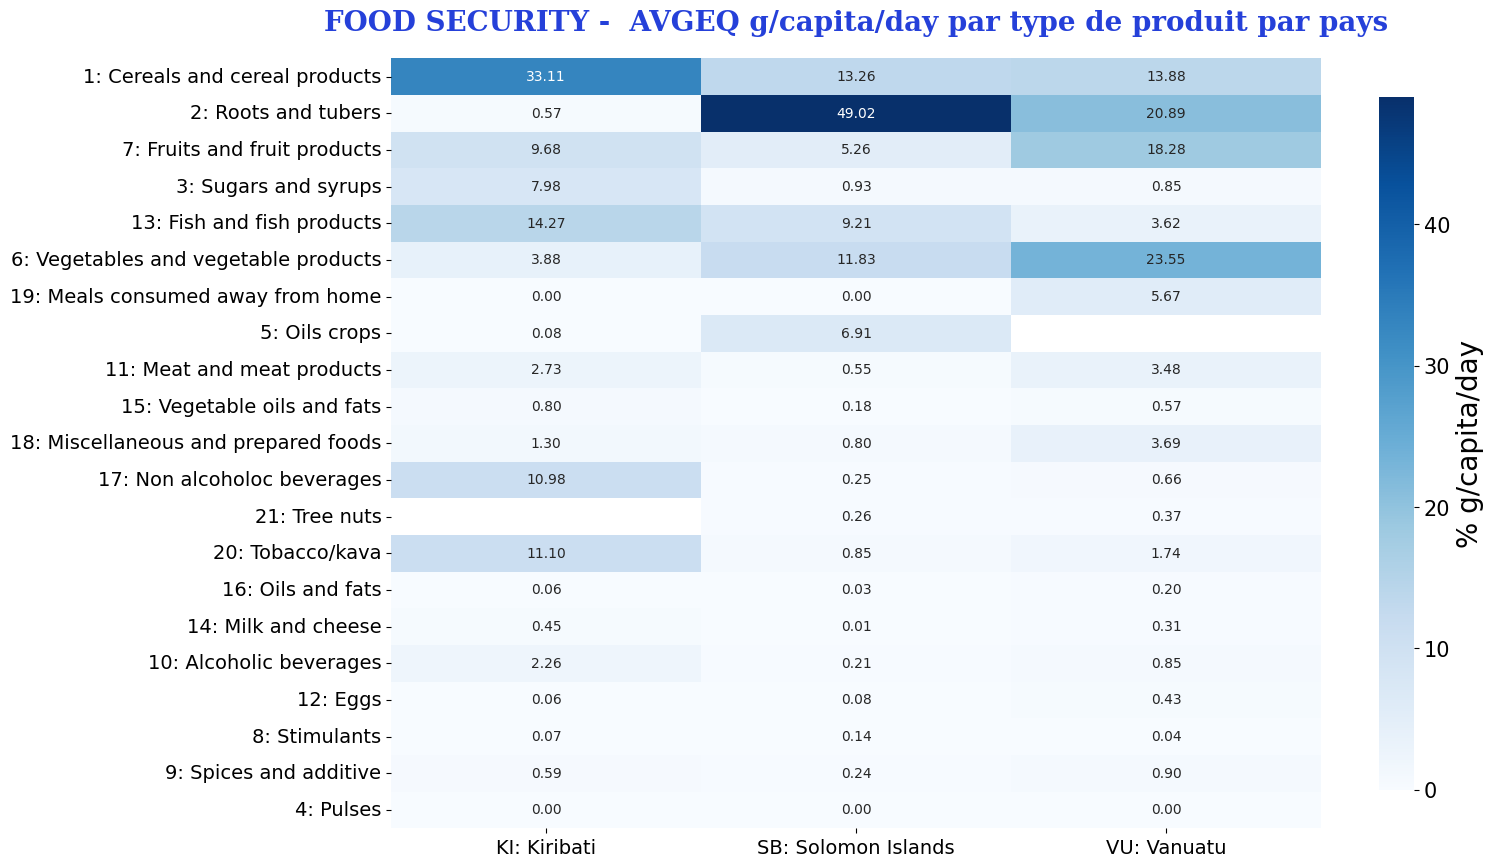

In [12]:
## GRAPHIQUE
TITLE = "FOOD SECURITY -  AVGEQ g/capita/day par type de produit par pays"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10)) # Nombre et disposition des zones de dessin

ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 20},pad=20)
ax = sns.heatmap(df_pivot_pays_total_AVGEQ, annot=True, square=False, cmap="Blues", cbar_kws={'label': '% g/capita/day', 'location' : 'right',"shrink": 0.9} ,fmt='.2f')
ax.set(xlabel="", ylabel="")
ax.figure.axes[-1].set_ylabel('% g/capita/day', size=20)
ax.figure.axes[-1].tick_params(labelsize=15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, rotation=0)

In [13]:
# Analyse n°2
pays_list = ['KI: Kiribati','SB: Solomon Islands','VU: Vanuatu']
df_pays = df_net[df_net['REGION'].isin(pays_list)]
df_pays_total = df_pays.loc[(df_pays['GENRE'] == '_T: Total') & \
                            (df_pays['AGE'] == '_T: All ages') & \
                            (df_pays['URBANISATION'] == '_T: National') & \
                            (df_pays['POVERTY'] == '_T: Total') & \
                            (df_pays['FOOD_SECURITY'] == '_T: Total')
                           ]
df_pays_total_AVGEXP = df_pays_total[df_pays_total['INDICATEUR'] == 'AVGEXP: Average expenditures']
df_gb_pays_total_AVGEXP = df_pays_total_AVGEXP.groupby(['REGION','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"kcal/capita/day"})
df_pivot_pays_total_AVGEXP = df_gb_pays_total_AVGEXP.pivot_table(columns='REGION', index='FOOD_CATEGORY', values='kcal/capita/day')
df_pivot_pays_total_AVGEXP.loc[:,'Total'] = df_pivot_pays_total_AVGEXP.sum(numeric_only=True, axis=1)
df_pivot_pays_total_AVGEXP = df_pivot_pays_total_AVGEXP.sort_values(by=['Total'], ascending=False)
df_pivot_pays_total_AVGEXP = df_pivot_pays_total_AVGEXP.iloc[:, :].apply(lambda x: (x*100 / x.sum()))
df_pivot_pays_total_AVGEXP = df_pivot_pays_total_AVGEXP.drop('Total',axis=1)
df_pivot_pays_total_AVGEXP = df_pivot_pays_total_AVGEXP.reindex(global_order)
# print(df_pivot_pays_total_AVGDEC)

[Text(0, 0.5, '1: Cereals and cereal products'),
 Text(0, 1.5, '2: Roots and tubers'),
 Text(0, 2.5, '7: Fruits and fruit products'),
 Text(0, 3.5, '3: Sugars and syrups'),
 Text(0, 4.5, '13: Fish and fish products'),
 Text(0, 5.5, '6: Vegetables and vegetable products'),
 Text(0, 6.5, '19: Meals consumed away from home'),
 Text(0, 7.5, '5: Oils crops'),
 Text(0, 8.5, '11: Meat and meat products'),
 Text(0, 9.5, '15: Vegetable oils and fats'),
 Text(0, 10.5, '18: Miscellaneous and prepared foods'),
 Text(0, 11.5, '17: Non alcoholoc beverages'),
 Text(0, 12.5, '21: Tree nuts'),
 Text(0, 13.5, '20: Tobacco/kava'),
 Text(0, 14.5, '16: Oils and fats'),
 Text(0, 15.5, '14: Milk and cheese'),
 Text(0, 16.5, '10: Alcoholic beverages'),
 Text(0, 17.5, '12: Eggs'),
 Text(0, 18.5, '8: Stimulants'),
 Text(0, 19.5, '9: Spices and additive'),
 Text(0, 20.5, '4: Pulses')]

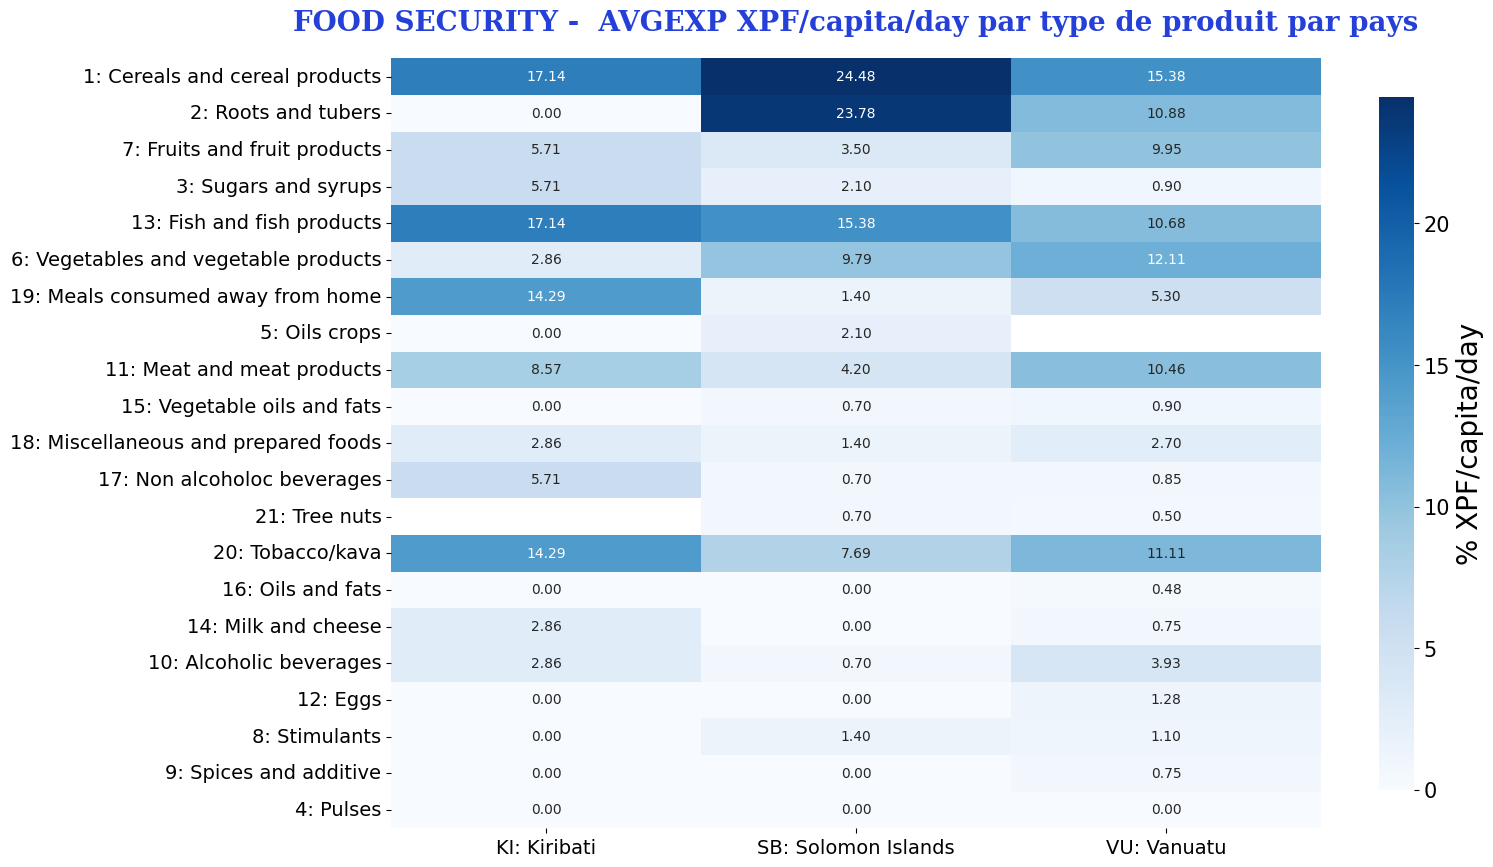

In [14]:
## GRAPHIQUE
TITLE = "FOOD SECURITY -  AVGEXP XPF/capita/day par type de produit par pays"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10)) # Nombre et disposition des zones de dessin

ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 20},pad=20)
ax = sns.heatmap(df_pivot_pays_total_AVGEXP, annot=True, square=False, cmap="Blues", cbar_kws={'label': '% XPF/capita/day', 'location' : 'right',"shrink": 0.9} ,fmt='.2f')
ax.set(xlabel="", ylabel="")
ax.figure.axes[-1].set_ylabel('% XPF/capita/day', size=20)
ax.figure.axes[-1].tick_params(labelsize=15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, rotation=0)

In [15]:
# # Analyse n°X
# pays_list = ['KI: Kiribati','SB: Solomon Islands','VU: Vanuatu']
# df_pays = df_net[df_net['REGION'].isin(pays_list)]
# df_pays_total = df_pays.loc[(df_pays['GENRE'] == '_T: Total') & \
#                             (df_pays['AGE'] == '_T: All ages') & \
#                             (df_pays['URBANISATION'] == '_T: National') & \
#                             (df_pays['POVERTY'] == '_T: Total') & \
#                             (df_pays['FOOD_SECURITY'] == '_T: Total')
#                            ]
# df_pays_total_AVGDEC = df_pays_total[df_pays_total['INDICATEUR'] == 'AVGDEC: Average Dietary Energy Consumption']
# df_gb_pays_total_AVGDEC = df_pays_total_AVGDEC.groupby(['REGION','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"kcal/capita/day"})
# df_pivot_pays_total_AVGDEC = df_gb_pays_total_AVGDEC.pivot_table(columns='REGION', index='FOOD_CATEGORY', values='kcal/capita/day')
# df_pivot_pays_total_AVGDEC.sort_index(inplace=True)

# df_pays_total_AVGEQ = df_pays_total[df_pays_total['INDICATEUR'] == 'AVGEQ: Average edible quantity']
# df_gb_pays_total_AVGEQ = df_pays_total_AVGEQ.groupby(['REGION','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"kcal/capita/day"})
# df_pivot_pays_total_AVGEQ = df_gb_pays_total_AVGEQ.pivot_table(columns='REGION', index='FOOD_CATEGORY', values='kcal/capita/day')
# df_pivot_pays_total_AVGEQ.sort_index(inplace=True)

# # print(df_pivot_pays_total_AVGDEC)
# # print(df_pivot_pays_total_AVGEQ)

# df_pays_AVGDEC_AVGEQ = df_pivot_pays_total_AVGDEC.divide(df_pivot_pays_total_AVGEQ.values)
# df_pays_AVGDEC_AVGEQ.loc[:,'Total'] = df_pays_AVGDEC_AVGEQ.sum(numeric_only=True, axis=1)
# df_pays_AVGDEC_AVGEQ = df_pays_AVGDEC_AVGEQ.sort_values(by=['Total'], ascending=False)
# df_pays_AVGDEC_AVGEQ.replace([np.inf, -np.inf], np.nan, inplace=True)
# df_pays_AVGDEC_AVGEQ = df_pays_AVGDEC_AVGEQ.drop('Total',axis=1)
# # df_value_per_pop = df_value_per_pop.iloc[:, :].apply(lambda x: x*1000)
# # df_value_per_pop = df_value_per_pop[df_value_per_pop.sum().sort_values(ascending=False).index[0:]]
# # print(df_pays_AVGDEC_AVGEQ)

In [16]:
# # Analyse n°X
# pays_list = ['KI: Kiribati','SB: Solomon Islands','VU: Vanuatu']
# df_pays = df_net[df_net['REGION'].isin(pays_list)]
# df_pays_total = df_pays.loc[(df_pays['GENRE'] == '_T: Total') & \
#                             (df_pays['AGE'] == '_T: All ages') & \
#                             (df_pays['URBANISATION'] == '_T: National') & \
#                             (df_pays['POVERTY'] == '_T: Total') & \
#                             (df_pays['FOOD_SECURITY'] == '_T: Total')
#                            ]
# df_pays_total_AVGDEC = df_pays_total[df_pays_total['INDICATEUR'] == 'AVGDEC: Average Dietary Energy Consumption']
# df_gb_pays_total_AVGDEC = df_pays_total_AVGDEC.groupby(['REGION','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"kcal/capita/day"})
# df_pivot_pays_total_AVGDEC = df_gb_pays_total_AVGDEC.pivot_table(columns='REGION', index='FOOD_CATEGORY', values='kcal/capita/day')
# df_pivot_pays_total_AVGDEC.sort_index(inplace=True)

# df_pays_total_AVGEXP = df_pays_total[df_pays_total['INDICATEUR'] == 'AVGEXP: Average expenditures']
# df_gb_pays_total_AVGEXP = df_pays_total_AVGEXP.groupby(['REGION','FOOD_CATEGORY']).agg({'PRIX_$':'sum'}).rename(columns={"PRIX_$":"XPF/capita/day"})
# df_pivot_pays_total_AVGEXP = df_gb_pays_total_AVGEXP.pivot_table(columns='REGION', index='FOOD_CATEGORY', values='XPF/capita/day')
# df_pivot_pays_total_AVGEXP.sort_index(inplace=True)

# # print(df_pivot_pays_total_AVGDEC)
# # print(df_pivot_pays_total_AVGEXP)

# df_pays_AVGDEC_AVGEXP = df_pivot_pays_total_AVGDEC.divide(df_pivot_pays_total_AVGEXP.values)
# df_pays_AVGDEC_AVGEXP.loc[:,'Total'] = df_pays_AVGDEC_AVGEXP.sum(numeric_only=True, axis=1)
# df_pays_AVGDEC_AVGEXP = df_pays_AVGDEC_AVGEXP.sort_values(by=['Total'], ascending=False)
# df_pays_AVGDEC_AVGEXP.replace([np.inf, -np.inf], np.nan, inplace=True)
# df_pays_AVGDEC_AVGEXP = df_pays_AVGDEC_AVGEXP.drop('Total',axis=1)
# # df_value_per_pop = df_value_per_pop.iloc[:, :].apply(lambda x: x*1000)
# # df_value_per_pop = df_value_per_pop[df_value_per_pop.sum().sort_values(ascending=False).index[0:]]
# # print(df_pays_AVGDEC_AVGEXP)

In [17]:
# # Analyse n°X
# pays_list = ['KI: Kiribati','SB: Solomon Islands','VU: Vanuatu']
# df_pays = df_net[df_net['REGION'].isin(pays_list)]
# df_pays_total = df_pays.loc[(df_pays['GENRE'] == '_T: Total') & \
#                             (df_pays['AGE'] == '_T: All ages') & \
#                             (df_pays['URBANISATION'] == '_T: National') & \
#                             (df_pays['POVERTY'] == '_T: Total') & \
#                             (df_pays['FOOD_SECURITY'] == '_T: Total')
#                            ]
# df_pays_total_AVGEQ = df_pays_total[df_pays_total['INDICATEUR'] == 'AVGEQ: Average edible quantity']
# df_gb_pays_total_AVGEQ = df_pays_total_AVGEQ.groupby(['REGION','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"g/capita/day"})
# df_pivot_pays_total_AVGEQ = df_gb_pays_total_AVGEQ.pivot_table(columns='REGION', index='FOOD_CATEGORY', values='g/capita/day')
# df_pivot_pays_total_AVGEQ.sort_index(inplace=True)

# df_pays_total_AVGEXP = df_pays_total[df_pays_total['INDICATEUR'] == 'AVGEXP: Average expenditures']
# df_gb_pays_total_AVGEXP = df_pays_total_AVGEXP.groupby(['REGION','FOOD_CATEGORY']).agg({'PRIX_$':'sum'}).rename(columns={"PRIX_$":"XPF/capita/day"})
# df_pivot_pays_total_AVGEXP = df_gb_pays_total_AVGEXP.pivot_table(columns='REGION', index='FOOD_CATEGORY', values='XPF/capita/day')
# df_pivot_pays_total_AVGEXP.sort_index(inplace=True)

# # print(df_pivot_pays_total_AVGDEC)
# # print(df_pivot_pays_total_AVGEXP)

# df_pays_AVGEQ_AVGEXP = df_pivot_pays_total_AVGEQ.divide(df_pivot_pays_total_AVGEXP.values)
# df_pays_AVGEQ_AVGEXP.loc[:,'Total'] = df_pays_AVGEQ_AVGEXP.sum(numeric_only=True, axis=1)
# df_pays_AVGEQ_AVGEXP = df_pays_AVGEQ_AVGEXP.sort_values(by=['Total'], ascending=False)
# df_pays_AVGEQ_AVGEXP.replace([np.inf, -np.inf], np.nan, inplace=True)
# df_pays_AVGEQ_AVGEXP = df_pays_AVGEQ_AVGEXP.drop('Total',axis=1)
# # df_value_per_pop = df_value_per_pop.iloc[:, :].apply(lambda x: x*1000)
# # df_value_per_pop = df_value_per_pop[df_value_per_pop.sum().sort_values(ascending=False).index[0:]]
# # print(df_pays_AVGEQ_AVGEXP)

In [18]:
# Analyse n°3
pays_list = ['KI: Kiribati','SB: Solomon Islands','VU: Vanuatu']
df_pays = df_net[df_net['REGION'].isin(pays_list)]
df_pays_total = df_pays.loc[(df_pays['GENRE'] == '_T: Total') & \
                            (df_pays['AGE'] == '_T: All ages') & \
                            (df_pays['URBANISATION'] == '_T: National') & \
                            (df_pays['POVERTY'] == '_T: Total') & \
                            (df_pays['FOOD_SECURITY'] == '_T: Total')
                           ]
df_pays_total_AVGNPRDCONS = df_pays_total[df_pays_total['INDICATEUR'] == 'AVGNPRDCONS: Average number of products consumed by household by food group']
df_gb_pays_total_AVGNPRDCONS = df_pays_total_AVGNPRDCONS.groupby(['REGION','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_total_AVGNPRDCONS= df_gb_pays_total_AVGNPRDCONS.pivot_table(columns='REGION', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_total_AVGNPRDCONS.loc[:,'Total'] = df_pivot_pays_total_AVGNPRDCONS.sum(numeric_only=True, axis=1)
df_pivot_pays_total_AVGNPRDCONS = df_pivot_pays_total_AVGNPRDCONS.sort_values(by=['Total'], ascending=False)
df_pivot_pays_total_AVGNPRDCONS = df_pivot_pays_total_AVGNPRDCONS.drop('Total',axis=1)
df_pivot_pays_total_AVGNPRDCONS = df_pivot_pays_total_AVGNPRDCONS.reindex(global_order)
print(df_pivot_pays_total_AVGNPRDCONS)

REGION                                KI: Kiribati  SB: Solomon Islands  \
FOOD_CATEGORY                                                             
1: Cereals and cereal products                 3.3                  4.7   
2: Roots and tubers                            1.2                  3.6   
7: Fruits and fruit products                   2.2                  2.8   
3: Sugars and syrups                           1.2                  1.5   
13: Fish and fish products                     2.6                  3.8   
6: Vegetables and vegetable products           1.6                  5.5   
19: Meals consumed away from home              6.2                  1.1   
5: Oils crops                                  1.0                  1.4   
11: Meat and meat products                     1.6                  1.8   
15: Vegetable oils and fats                    1.1                  1.2   
18: Miscellaneous and prepared foods           2.1                  2.1   
17: Non alcoholoc beverag

[Text(0, 0.5, '1: Cereals and cereal products'),
 Text(0, 1.5, '2: Roots and tubers'),
 Text(0, 2.5, '7: Fruits and fruit products'),
 Text(0, 3.5, '3: Sugars and syrups'),
 Text(0, 4.5, '13: Fish and fish products'),
 Text(0, 5.5, '6: Vegetables and vegetable products'),
 Text(0, 6.5, '19: Meals consumed away from home'),
 Text(0, 7.5, '5: Oils crops'),
 Text(0, 8.5, '11: Meat and meat products'),
 Text(0, 9.5, '15: Vegetable oils and fats'),
 Text(0, 10.5, '18: Miscellaneous and prepared foods'),
 Text(0, 11.5, '17: Non alcoholoc beverages'),
 Text(0, 12.5, '21: Tree nuts'),
 Text(0, 13.5, '20: Tobacco/kava'),
 Text(0, 14.5, '16: Oils and fats'),
 Text(0, 15.5, '14: Milk and cheese'),
 Text(0, 16.5, '10: Alcoholic beverages'),
 Text(0, 17.5, '12: Eggs'),
 Text(0, 18.5, '8: Stimulants'),
 Text(0, 19.5, '9: Spices and additive'),
 Text(0, 20.5, '4: Pulses')]

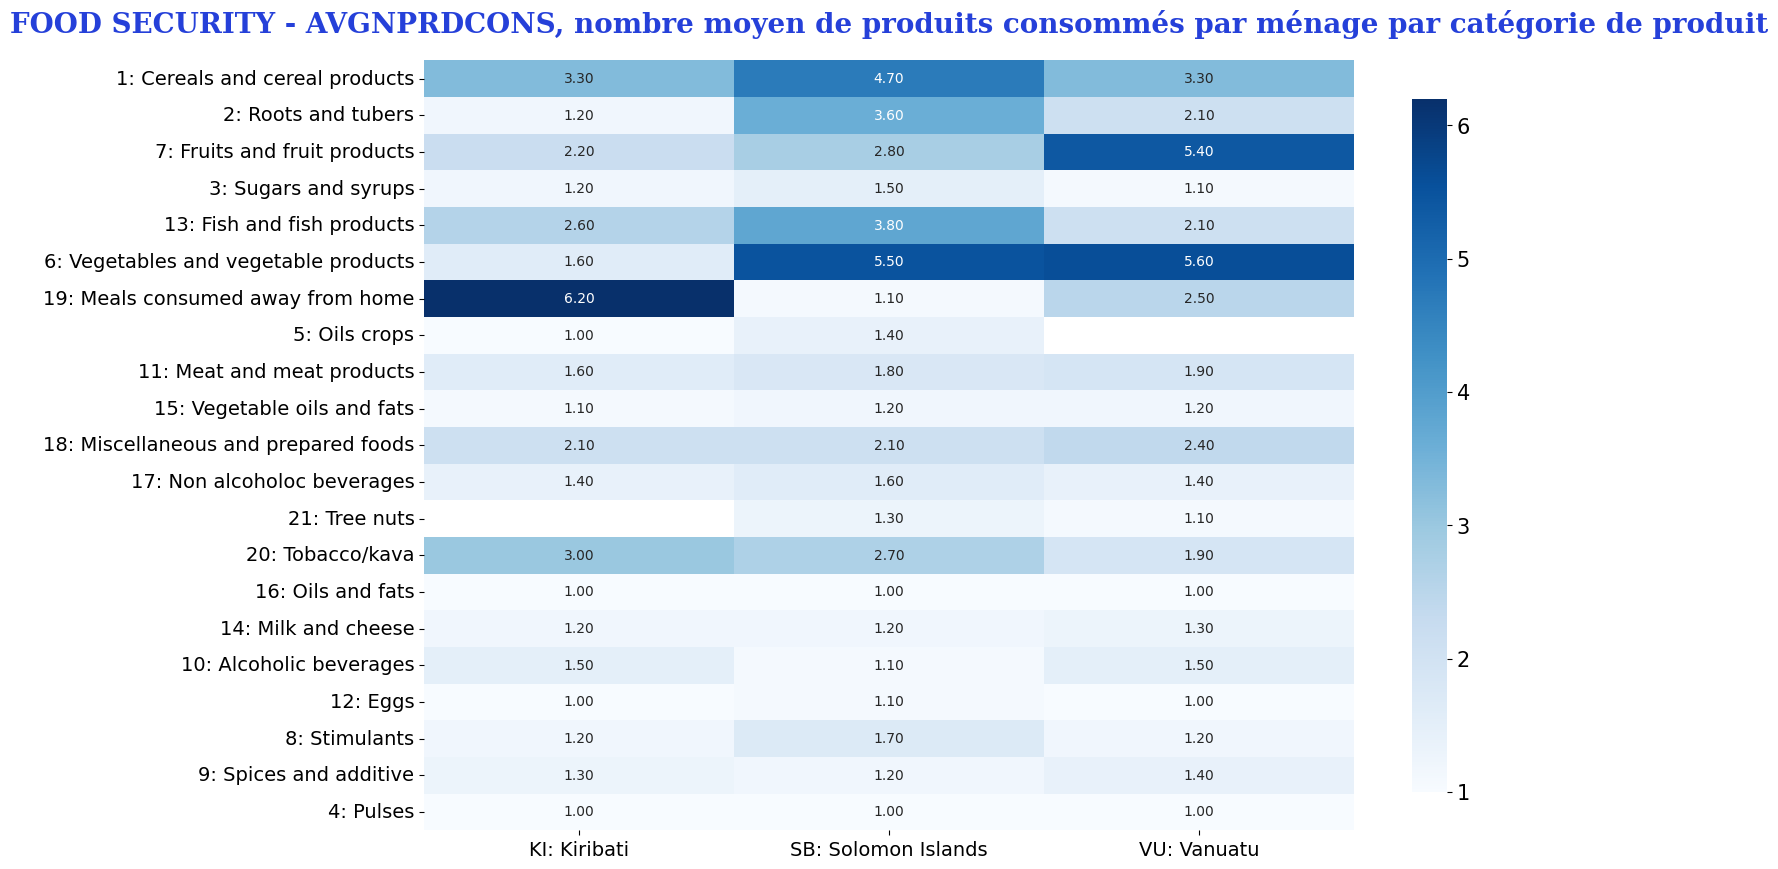

In [19]:
## GRAPHIQUE
TITLE = "FOOD SECURITY - AVGNPRDCONS, nombre moyen de produits consommés par ménage par catégorie de produit"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10)) # Nombre et disposition des zones de dessin

ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 20},pad=20)
ax = sns.heatmap(df_pivot_pays_total_AVGNPRDCONS, annot=True, square=False, cmap="Blues", cbar_kws={'label': '', 'location' : 'right',"shrink": 0.9} ,fmt='.2f')
ax.set(xlabel="", ylabel="")
ax.figure.axes[-1].set_ylabel('', size=20)
ax.figure.axes[-1].tick_params(labelsize=15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, rotation=0)

[Text(0.25, 0, '1: Cereals and cereal products'),
 Text(1.25, 0, '2: Roots and tubers'),
 Text(2.25, 0, '7: Fruits and fruit products'),
 Text(3.25, 0, '3: Sugars and syrups'),
 Text(4.25, 0, '13: Fish and fish products'),
 Text(5.25, 0, '6: Vegetables and vegetable products'),
 Text(6.25, 0, '19: Meals consumed away from home'),
 Text(7.25, 0, '5: Oils crops'),
 Text(8.25, 0, '11: Meat and meat products'),
 Text(9.25, 0, '15: Vegetable oils and fats'),
 Text(10.25, 0, '18: Miscellaneous and prepared foods'),
 Text(11.25, 0, '17: Non alcoholoc beverages'),
 Text(12.25, 0, '21: Tree nuts'),
 Text(13.25, 0, '20: Tobacco/kava'),
 Text(14.25, 0, '16: Oils and fats'),
 Text(15.25, 0, '14: Milk and cheese'),
 Text(16.25, 0, '10: Alcoholic beverages'),
 Text(17.25, 0, '12: Eggs'),
 Text(18.25, 0, '8: Stimulants'),
 Text(19.25, 0, '9: Spices and additive'),
 Text(20.25, 0, '4: Pulses')]

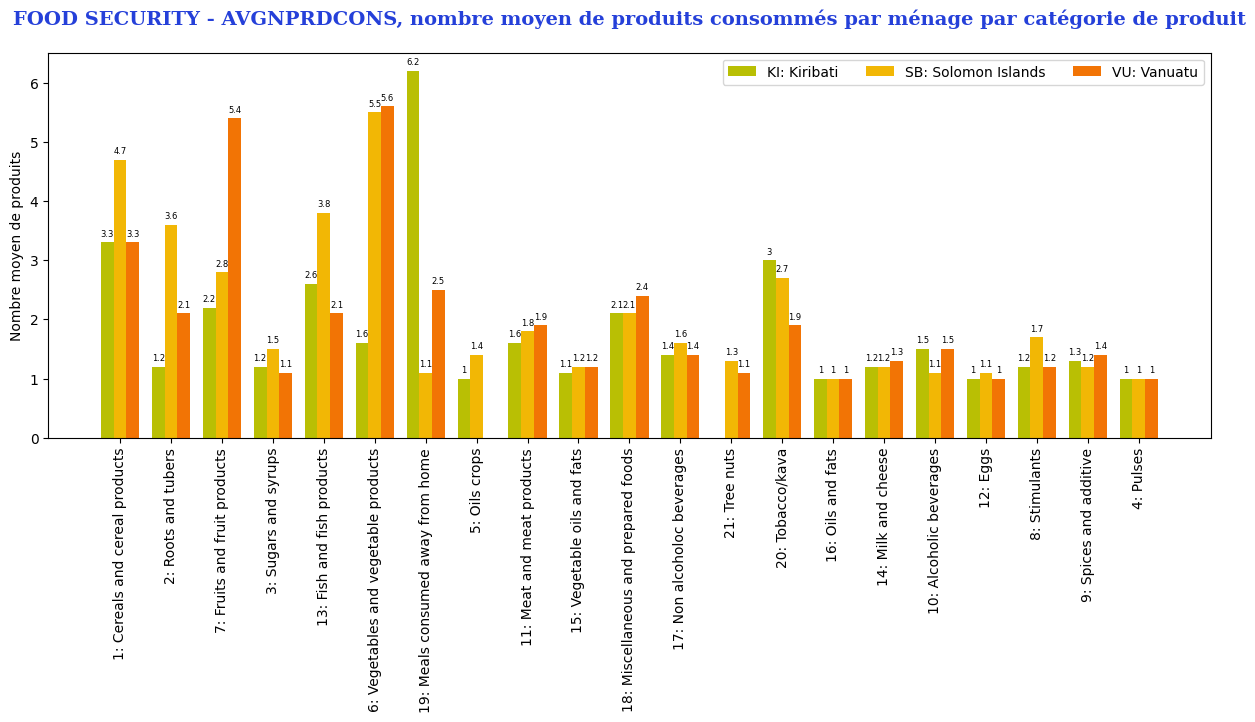

In [20]:
## GRAPHIQUE
TITLE = "FOOD SECURITY - AVGNPRDCONS, nombre moyen de produits consommés par ménage par catégorie de produit"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5)) # Nombre et disposition des zones de dessin
ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 14},pad=20)


# bar_labels = ['KI: Kiribati', 'SB: Solomon Islands', 'VU: Vanuatu']

categories = df_pivot_pays_total_AVGNPRDCONS.index.to_list()
pays = {
    'KI: Kiribati': df_pivot_pays_total_AVGNPRDCONS['KI: Kiribati'].to_list(),
    'SB: Solomon Islands': df_pivot_pays_total_AVGNPRDCONS['SB: Solomon Islands'].to_list(),
    'VU: Vanuatu': df_pivot_pays_total_AVGNPRDCONS['VU: Vanuatu'].to_list(),
}

x = np.arange(len(categories))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0
bar_colors = ['#B9BF04', '#F2B705', '#F27405']
i=0
for attribute, measurement in pays.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=bar_colors[i])
    ax.bar_label(rects, padding=3, fontsize=6)
    multiplier += 1
    i+=1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Nombre moyen de produits')
# ax.set_title('Catégories')
ax.set_xticks(x + width, categories)
ax.legend(loc='upper right', ncols=3)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=90)
# ax.set_ylim(0, 250)

In [21]:
# Analyse n°3
pays_list = ['KI: Kiribati','SB: Solomon Islands','VU: Vanuatu']
df_pays = df_net[df_net['REGION'].isin(pays_list)]
df_pays_total = df_pays.loc[(df_pays['GENRE'] == '_T: Total') & \
                            (df_pays['AGE'] == '_T: All ages') & \
                            (df_pays['URBANISATION'] == '_T: National') & \
                            (df_pays['POVERTY'] == '_T: Total') & \
                            (df_pays['FOOD_SECURITY'] == '_T: Total')
                           ]
df_pays_total_CONSAL1 = df_pays_total[df_pays_total['INDICATEUR'] == 'CONSAL1: Percentage of HH who consumed at least one product of the group']
df_gb_pays_total_CONSAL1 = df_pays_total_CONSAL1.groupby(['REGION','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_total_CONSAL1= df_gb_pays_total_CONSAL1.pivot_table(columns='REGION', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_total_CONSAL1.loc[:,'Total'] = df_pivot_pays_total_CONSAL1.sum(numeric_only=True, axis=1)
df_pivot_pays_total_CONSAL1 = df_pivot_pays_total_CONSAL1.sort_values(by=['Total'], ascending=False)
df_pivot_pays_total_CONSAL1 = df_pivot_pays_total_CONSAL1.drop('Total',axis=1)
df_pivot_pays_total_CONSAL1 = df_pivot_pays_total_CONSAL1.reindex(global_order)
print(df_pivot_pays_total_CONSAL1)

REGION                                KI: Kiribati  SB: Solomon Islands  \
FOOD_CATEGORY                                                             
1: Cereals and cereal products                98.0                 99.3   
2: Roots and tubers                           14.6                 98.0   
7: Fruits and fruit products                  84.6                 78.3   
3: Sugars and syrups                          90.9                 77.9   
13: Fish and fish products                    97.5                 97.9   
6: Vegetables and vegetable products          50.5                 98.6   
19: Meals consumed away from home             75.4                 29.3   
5: Oils crops                                 18.8                 80.4   
11: Meat and meat products                    61.2                 44.1   
15: Vegetable oils and fats                   73.7                 27.6   
18: Miscellaneous and prepared foods          65.5                 58.2   
17: Non alcoholoc beverag

[Text(0, 0.5, '1: Cereals and cereal products'),
 Text(0, 1.5, '2: Roots and tubers'),
 Text(0, 2.5, '7: Fruits and fruit products'),
 Text(0, 3.5, '3: Sugars and syrups'),
 Text(0, 4.5, '13: Fish and fish products'),
 Text(0, 5.5, '6: Vegetables and vegetable products'),
 Text(0, 6.5, '19: Meals consumed away from home'),
 Text(0, 7.5, '5: Oils crops'),
 Text(0, 8.5, '11: Meat and meat products'),
 Text(0, 9.5, '15: Vegetable oils and fats'),
 Text(0, 10.5, '18: Miscellaneous and prepared foods'),
 Text(0, 11.5, '17: Non alcoholoc beverages'),
 Text(0, 12.5, '21: Tree nuts'),
 Text(0, 13.5, '20: Tobacco/kava'),
 Text(0, 14.5, '16: Oils and fats'),
 Text(0, 15.5, '14: Milk and cheese'),
 Text(0, 16.5, '10: Alcoholic beverages'),
 Text(0, 17.5, '12: Eggs'),
 Text(0, 18.5, '8: Stimulants'),
 Text(0, 19.5, '9: Spices and additive'),
 Text(0, 20.5, '4: Pulses')]

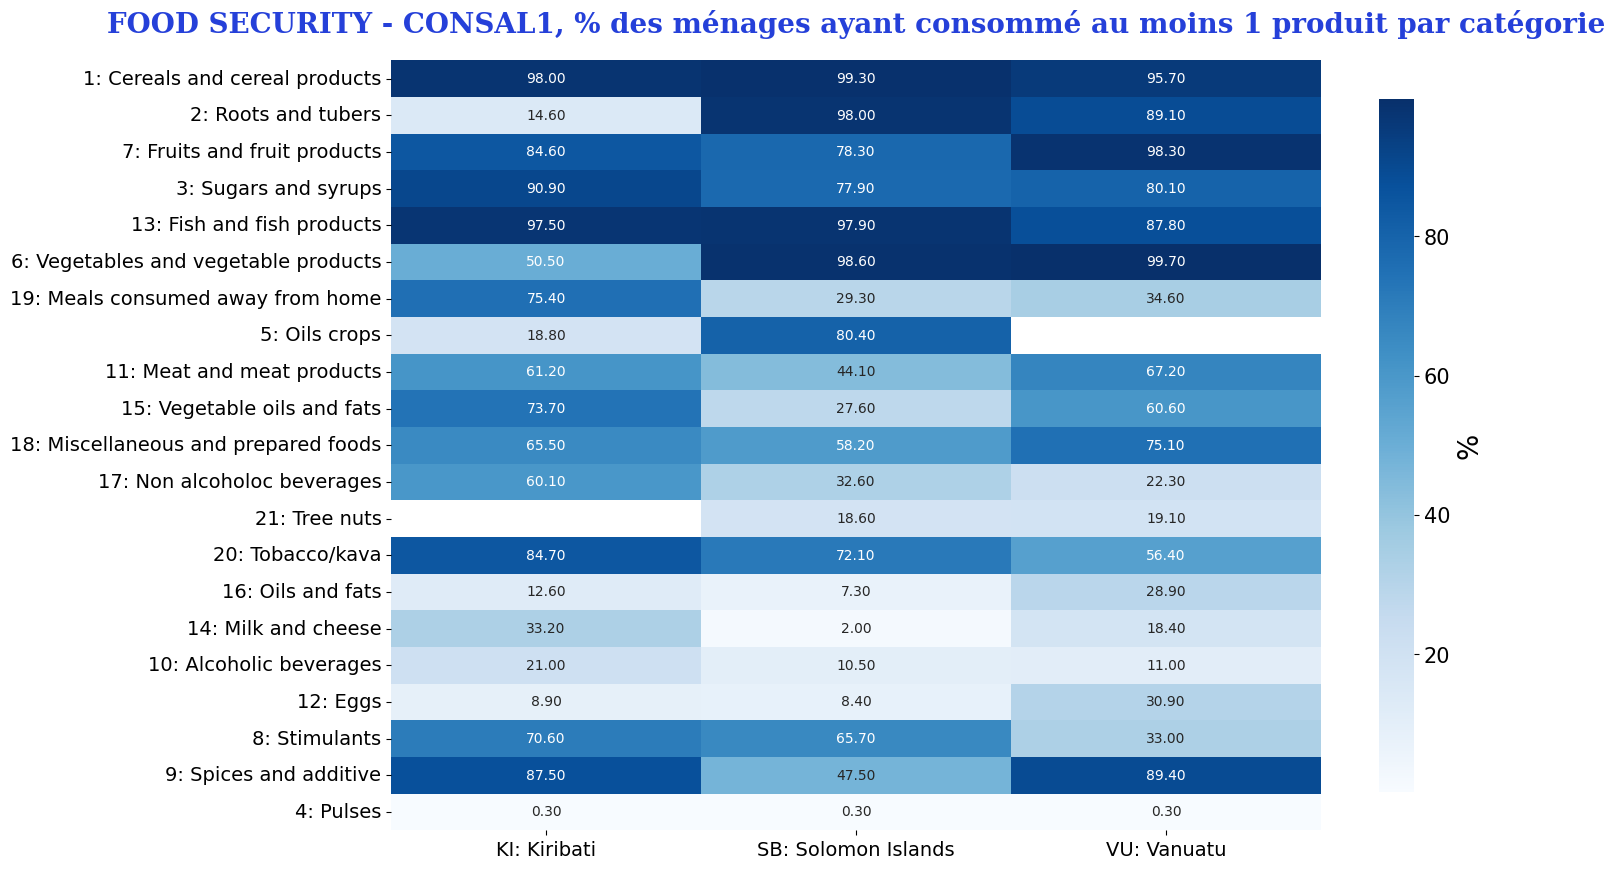

In [22]:
## GRAPHIQUE
TITLE = "FOOD SECURITY - CONSAL1, % des ménages ayant consommé au moins 1 produit par catégorie"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10)) # Nombre et disposition des zones de dessin

ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 20},pad=20)
ax = sns.heatmap(df_pivot_pays_total_CONSAL1, annot=True, square=False, cmap="Blues", cbar_kws={'label': '%', 'location' : 'right',"shrink": 0.9} ,fmt='.2f')
ax.set(xlabel="", ylabel="")
ax.figure.axes[-1].set_ylabel('%', size=20)
ax.figure.axes[-1].tick_params(labelsize=15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, rotation=0)

In [23]:
# Analyse n°3
pays_list = ['KI: Kiribati','SB: Solomon Islands','VU: Vanuatu']
df_pays = df_net[df_net['REGION'].isin(pays_list)]
df_pays_total = df_pays.loc[(df_pays['GENRE'] == '_T: Total') & \
                            (df_pays['AGE'] == '_T: All ages') & \
                            (df_pays['URBANISATION'] == '_T: National') & \
                            (df_pays['POVERTY'] == '_T: Total') & \
                            (df_pays['FOOD_SECURITY'] == '_T: Total')
                           ]
df_pays_total_CONSLTAVG = df_pays_total[df_pays_total['INDICATEUR'] == 'CONSLTAVG: Percentage of households who consumed less than the average number of products consumed in the group']
df_gb_pays_total_CONSLTAVG = df_pays_total_CONSLTAVG.groupby(['REGION','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_total_CONSLTAVG= df_gb_pays_total_CONSLTAVG.pivot_table(columns='REGION', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_total_CONSLTAVG.loc[:,'Total'] = df_pivot_pays_total_CONSLTAVG.sum(numeric_only=True, axis=1)
df_pivot_pays_total_CONSLTAVG = df_pivot_pays_total_CONSLTAVG.sort_values(by=['Total'], ascending=False)
df_pivot_pays_total_CONSLTAVG = df_pivot_pays_total_CONSLTAVG.drop('Total',axis=1)
df_pivot_pays_total_CONSLTAVG = df_pivot_pays_total_CONSLTAVG.reindex(global_order)
# print(df_pivot_pays_total_CONSLTAVG)

# Analyse n°3
pays_list = ['KI: Kiribati','SB: Solomon Islands','VU: Vanuatu']
df_pays = df_net[df_net['REGION'].isin(pays_list)]
df_pays_total = df_pays.loc[(df_pays['GENRE'] == '_T: Total') & \
                            (df_pays['AGE'] == '_T: All ages') & \
                            (df_pays['URBANISATION'] == '_T: National') & \
                            (df_pays['POVERTY'] == '_T: Total') & \
                            (df_pays['FOOD_SECURITY'] == '_T: Total')
                           ]
df_pays_total_CONSGTAVG = df_pays_total[df_pays_total['INDICATEUR'] == 'CONSGTAVG: Percentage of households who consumed more than the average number of products consumed in the group']
df_gb_pays_total_CONSGTAVG = df_pays_total_CONSGTAVG.groupby(['REGION','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_total_CONSGTAVG= df_gb_pays_total_CONSGTAVG.pivot_table(columns='REGION', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_total_CONSGTAVG.loc[:,'Total'] = df_pivot_pays_total_CONSGTAVG.sum(numeric_only=True, axis=1)
df_pivot_pays_total_CONSGTAVG = df_pivot_pays_total_CONSGTAVG.sort_values(by=['Total'], ascending=False)
df_pivot_pays_total_CONSGTAVG = df_pivot_pays_total_CONSGTAVG.drop('Total',axis=1)
df_pivot_pays_total_CONSGTAVG = df_pivot_pays_total_CONSGTAVG.reindex(global_order)
# print(df_pivot_pays_total_CONSGTAVG)

[Text(0, 0.5, '1: Cereals and cereal products'),
 Text(0, 1.5, '2: Roots and tubers'),
 Text(0, 2.5, '7: Fruits and fruit products'),
 Text(0, 3.5, '3: Sugars and syrups'),
 Text(0, 4.5, '13: Fish and fish products'),
 Text(0, 5.5, '6: Vegetables and vegetable products'),
 Text(0, 6.5, '19: Meals consumed away from home'),
 Text(0, 7.5, '5: Oils crops'),
 Text(0, 8.5, '11: Meat and meat products'),
 Text(0, 9.5, '15: Vegetable oils and fats'),
 Text(0, 10.5, '18: Miscellaneous and prepared foods'),
 Text(0, 11.5, '17: Non alcoholoc beverages'),
 Text(0, 12.5, '21: Tree nuts'),
 Text(0, 13.5, '20: Tobacco/kava'),
 Text(0, 14.5, '16: Oils and fats'),
 Text(0, 15.5, '14: Milk and cheese'),
 Text(0, 16.5, '10: Alcoholic beverages'),
 Text(0, 17.5, '12: Eggs'),
 Text(0, 18.5, '8: Stimulants'),
 Text(0, 19.5, '9: Spices and additive'),
 Text(0, 20.5, '4: Pulses')]

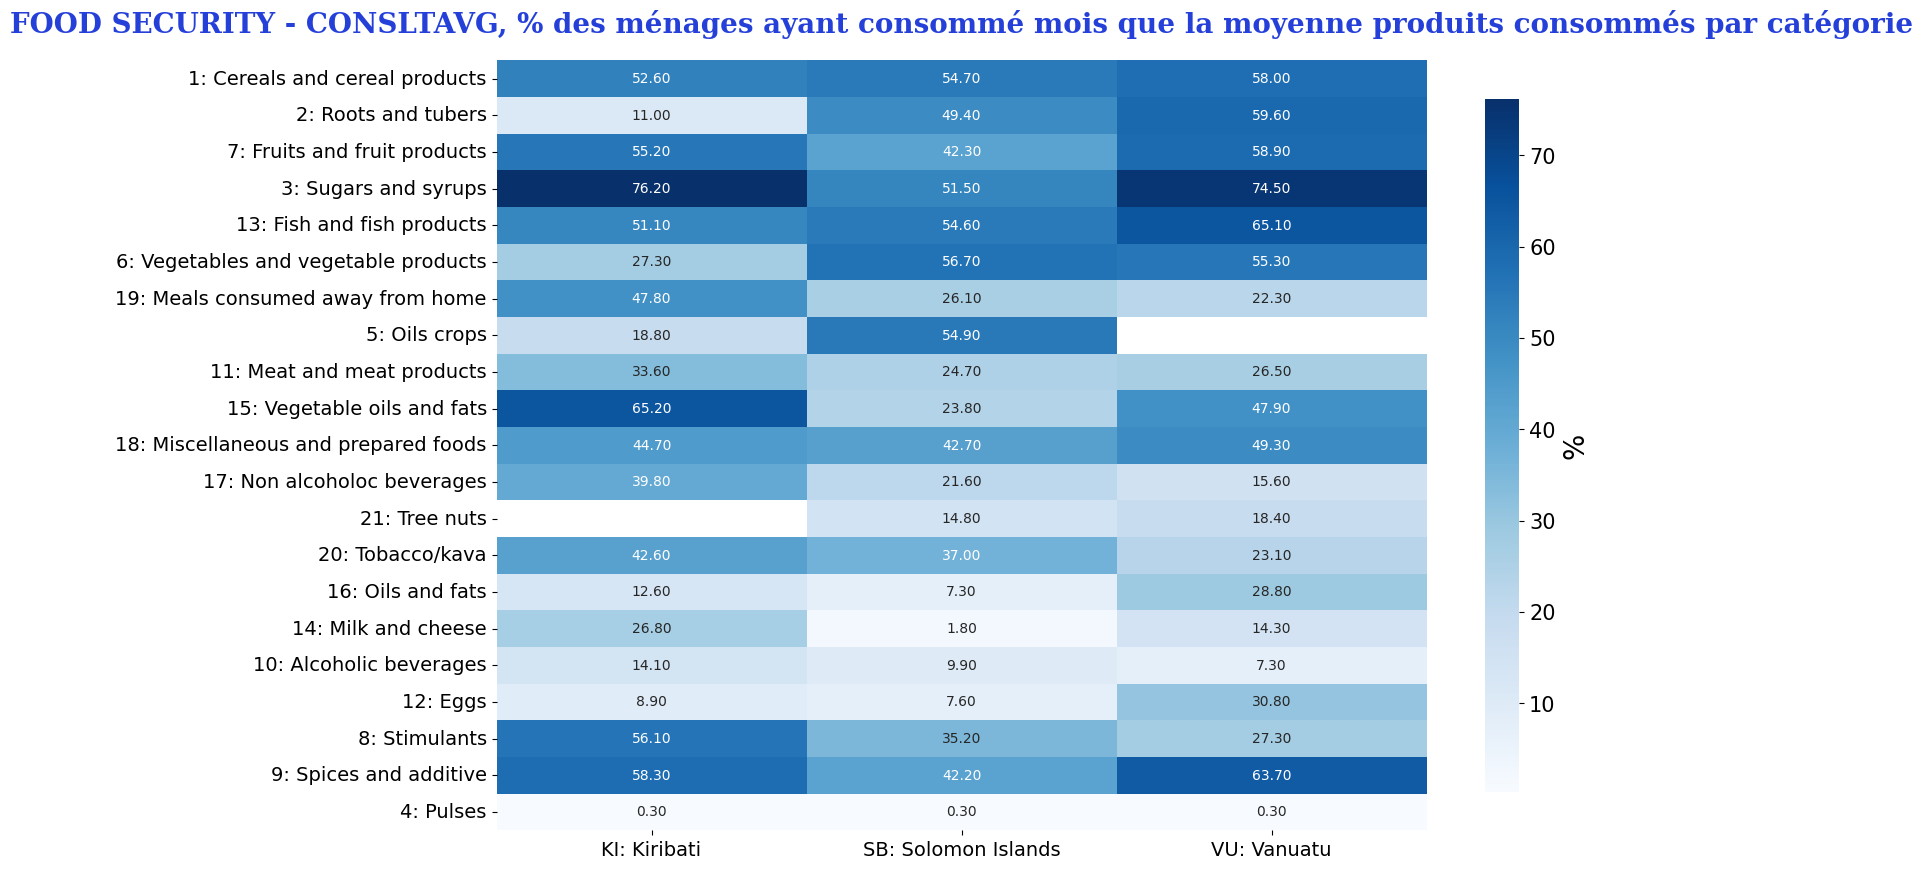

In [24]:
## GRAPHIQUE
TITLE = "FOOD SECURITY - CONSLTAVG, % des ménages ayant consommé mois que la moyenne produits consommés par catégorie"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10)) # Nombre et disposition des zones de dessin

ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 20},pad=20)
ax = sns.heatmap(df_pivot_pays_total_CONSLTAVG, annot=True, square=False, cmap="Blues", cbar_kws={'label': '%', 'location' : 'right',"shrink": 0.9} ,fmt='.2f')
ax.set(xlabel="", ylabel="")
ax.figure.axes[-1].set_ylabel('%', size=20)
ax.figure.axes[-1].tick_params(labelsize=15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, rotation=0)

[Text(0, 0.5, '1: Cereals and cereal products'),
 Text(0, 1.5, '2: Roots and tubers'),
 Text(0, 2.5, '7: Fruits and fruit products'),
 Text(0, 3.5, '3: Sugars and syrups'),
 Text(0, 4.5, '13: Fish and fish products'),
 Text(0, 5.5, '6: Vegetables and vegetable products'),
 Text(0, 6.5, '19: Meals consumed away from home'),
 Text(0, 7.5, '5: Oils crops'),
 Text(0, 8.5, '11: Meat and meat products'),
 Text(0, 9.5, '15: Vegetable oils and fats'),
 Text(0, 10.5, '18: Miscellaneous and prepared foods'),
 Text(0, 11.5, '17: Non alcoholoc beverages'),
 Text(0, 12.5, '21: Tree nuts'),
 Text(0, 13.5, '20: Tobacco/kava'),
 Text(0, 14.5, '16: Oils and fats'),
 Text(0, 15.5, '14: Milk and cheese'),
 Text(0, 16.5, '10: Alcoholic beverages'),
 Text(0, 17.5, '12: Eggs'),
 Text(0, 18.5, '8: Stimulants'),
 Text(0, 19.5, '9: Spices and additive'),
 Text(0, 20.5, '4: Pulses')]

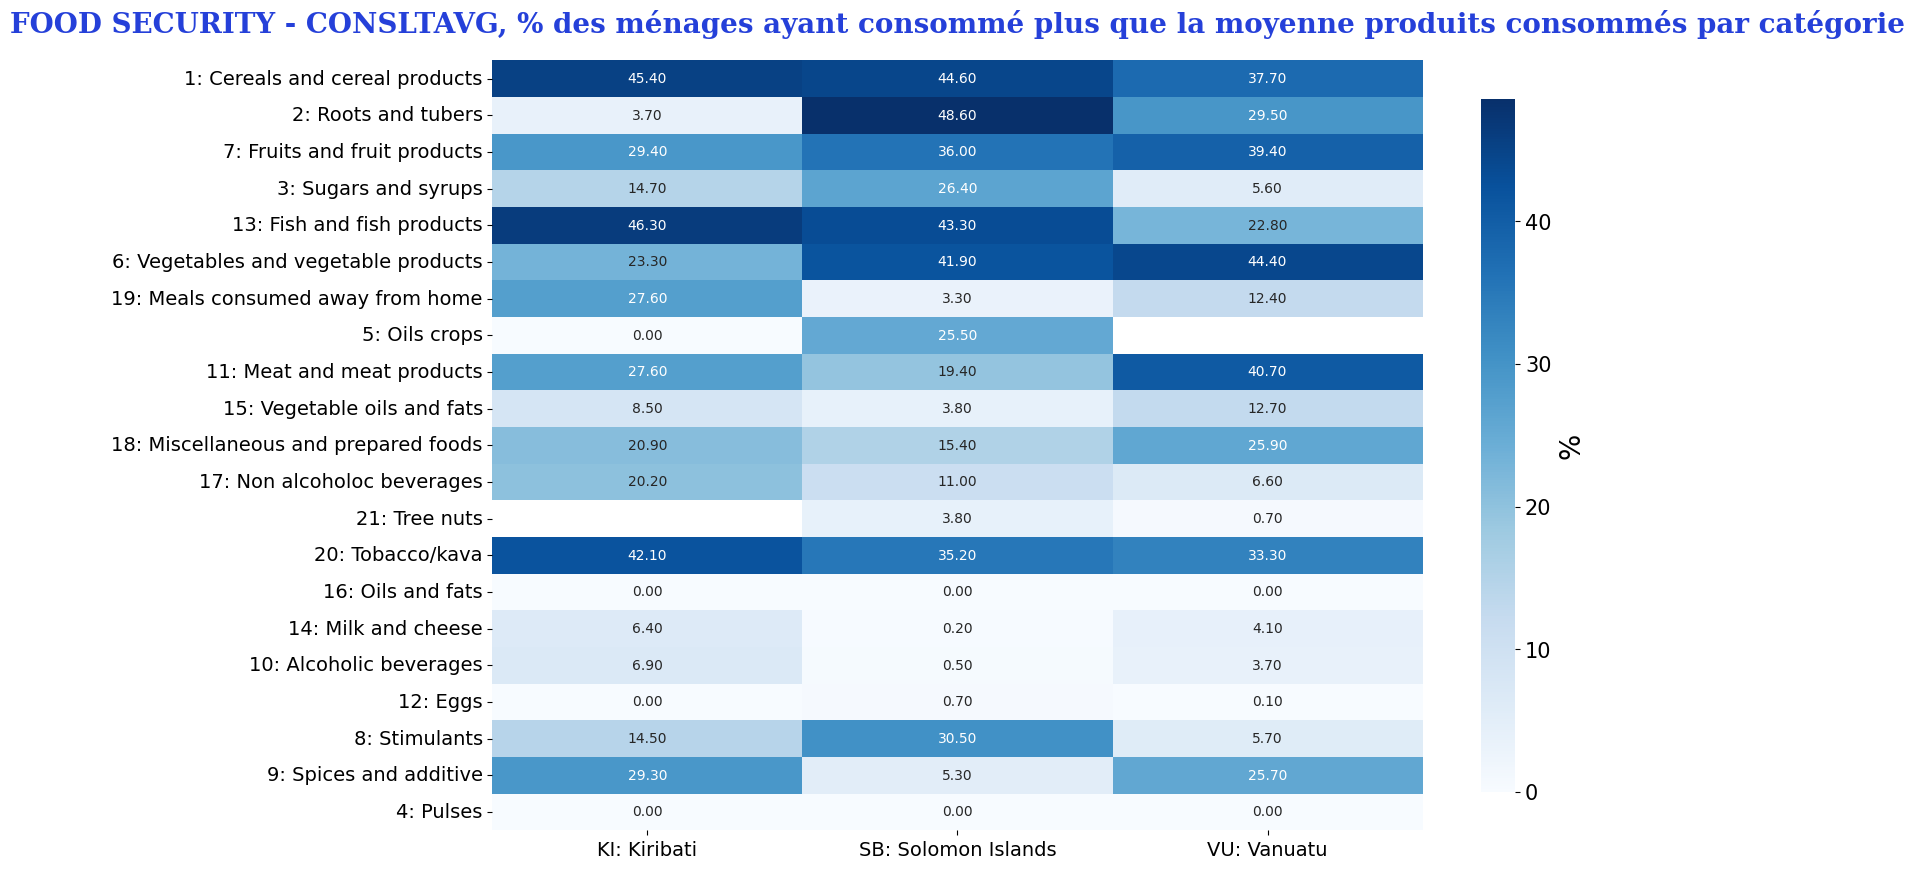

In [25]:
## GRAPHIQUE
TITLE = "FOOD SECURITY - CONSLTAVG, % des ménages ayant consommé plus que la moyenne produits consommés par catégorie"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10)) # Nombre et disposition des zones de dessin

ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 20},pad=20)
ax = sns.heatmap(df_pivot_pays_total_CONSGTAVG, annot=True, square=False, cmap="Blues", cbar_kws={'label': '%', 'location' : 'right',"shrink": 0.9} ,fmt='.2f')
ax.set(xlabel="", ylabel="")
ax.figure.axes[-1].set_ylabel('%', size=20)
ax.figure.axes[-1].tick_params(labelsize=15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, rotation=0)

REGION                                KI: Kiribati  SB: Solomon Islands  \
FOOD_CATEGORY                                                             
1: Cereals and cereal products           46.657720            26.611376   
2: Roots and tubers                       0.420732            32.507763   
7: Fruits and fruit products              7.464365             2.874347   
3: Sugars and syrups                     13.749955             2.177535   
13: Fish and fish products                8.106344             6.790123   
6: Vegetables and vegetable products      0.678249             4.790578   
19: Meals consumed away from home        11.954590             1.401197   
5: Oils crops                             0.058032            17.496024   
11: Meat and meat products                2.560662             0.617284   
15: Vegetable oils and fats               3.082949             0.946755   
18: Miscellaneous and prepared foods      0.638352             0.829357   
17: Non alcoholoc beverag

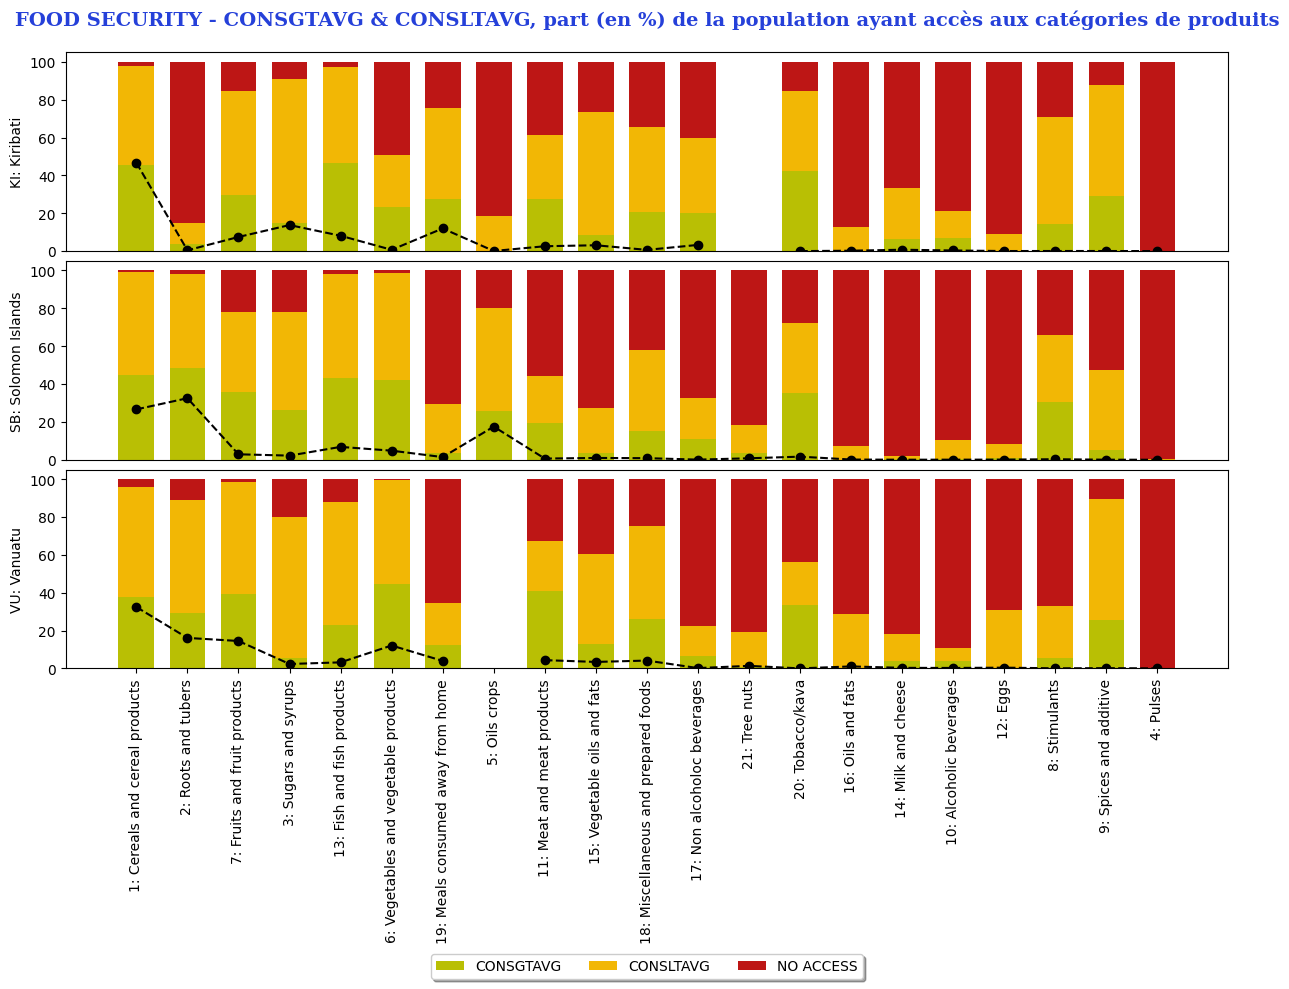

In [26]:
## GRAPHIQUE
TITLE = "FOOD SECURITY - CONSGTAVG & CONSLTAVG, part (en %) de la population ayant accès aux catégories de produits"
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,8)) # Nombre et disposition des zones de dessin
fig.subplots_adjust(hspace=0.05)
plt.xticks(rotation=90)
ax[0].set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 14},pad=20)

width = 0.7
categories = df_pivot_pays_total_CONSLTAVG.index.to_list()
bar_colors = ['#B9BF04', '#F2B705', '#BD1615']

# 1
NO_ACCESS_KI = [100 - (a_i + b_i) for a_i, b_i in zip(df_pivot_pays_total_CONSGTAVG['KI: Kiribati'].to_list(), df_pivot_pays_total_CONSLTAVG['KI: Kiribati'].to_list())]
pourcentages_KI = {
    "CONSGTAVG": df_pivot_pays_total_CONSGTAVG['KI: Kiribati'].to_list(),
    "CONSLTAVG": df_pivot_pays_total_CONSLTAVG['KI: Kiribati'].to_list(),
    "NO ACCESS": NO_ACCESS_KI,
}


print(df_pivot_pays_total_AVGDEC)


i=0
bottom_ki = np.zeros(len(df_pivot_pays_total_CONSLTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_KI.items():
    p = ax[0].bar(categories, pourcentage, width, label=boolean, bottom=bottom_ki, color=bar_colors[i])
    bottom_ki += pourcentage
    i += 1
ax[0].plot(df_pivot_pays_total_AVGDEC.index.values, df_pivot_pays_total_AVGDEC['KI: Kiribati'], 'black',linestyle='--', marker='o',linewidth=1.5)
ax[0].set_xticks([])
ax[0].set_ylabel('KI: Kiribati')
# 2
NO_ACCESS_SB = [100 - (a_i + b_i) for a_i, b_i in zip(df_pivot_pays_total_CONSGTAVG['SB: Solomon Islands'].to_list(), df_pivot_pays_total_CONSLTAVG['SB: Solomon Islands'].to_list())]
pourcentages_SB = {
    "CONSGTAVG": df_pivot_pays_total_CONSGTAVG['SB: Solomon Islands'].to_list(),
    "CONSLTAVG": df_pivot_pays_total_CONSLTAVG['SB: Solomon Islands'].to_list(),
    "NO ACCESS": NO_ACCESS_SB,
}

i=0
bottom_sb = np.zeros(len(df_pivot_pays_total_CONSLTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_SB.items():
    p = ax[1].bar(categories, pourcentage, width, label=boolean, bottom=bottom_sb, color=bar_colors[i])
    bottom_sb += pourcentage
    i += 1
ax[1].plot(df_pivot_pays_total_AVGDEC.index.values, df_pivot_pays_total_AVGDEC['SB: Solomon Islands'], 'black',linestyle='--', marker='o',linewidth=1.5)
ax[1].set_xticks([])
ax[1].set_ylabel('SB: Solomon Islands')

# 3
NO_ACCESS_VU = [100 - (a_i + b_i) for a_i, b_i in zip(df_pivot_pays_total_CONSGTAVG['VU: Vanuatu'].to_list(), df_pivot_pays_total_CONSLTAVG['VU: Vanuatu'].to_list())]
pourcentages_VU = {
    "CONSGTAVG": df_pivot_pays_total_CONSGTAVG['VU: Vanuatu'].to_list(),
    "CONSLTAVG": df_pivot_pays_total_CONSLTAVG['VU: Vanuatu'].to_list(),
    "NO ACCESS": NO_ACCESS_VU,
}

i=0
bottom_vu = np.zeros(len(df_pivot_pays_total_CONSLTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_VU.items():
    p = ax[2].bar(categories, pourcentage, width, label=boolean, bottom=bottom_vu, color=bar_colors[i])
    bottom_vu += pourcentage
    i += 1
ax[2].plot(df_pivot_pays_total_AVGDEC.index.values, df_pivot_pays_total_AVGDEC['VU: Vanuatu'], 'black',linestyle='--', marker='o',linewidth=1.5)
ax[2].set_ylabel('VU: Vanuatu')
# Légende
ax[0].legend(loc="center",bbox_to_anchor=(0,0,1,-7.2), ncol=3, fancybox=True, shadow=True)


In [27]:
# Analyse n°4
pays_list = ['KI: Kiribati']
df_pays = df_net[df_net['REGION'].isin(pays_list)]
df_pays_sex = df_pays.loc[#(df_pays['GENRE'] == '_T: Total') & \
                            (df_pays['AGE'] == '_T: All ages') & \
                            (df_pays['URBANISATION'] == '_T: National') & \
                            (df_pays['POVERTY'] == '_T: Total') & \
                            (df_pays['FOOD_SECURITY'] == '_T: Total')
                           ]
df_pays_sex_AVGNPRDCONS = df_pays_sex[df_pays_sex['INDICATEUR'] == 'AVGNPRDCONS: Average number of products consumed by household by food group']
df_pays_sex_AVGNPRDCONS = df_pays_sex_AVGNPRDCONS.groupby(['GENRE','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_sex_AVGNPRDCONS= df_pays_sex_AVGNPRDCONS.pivot_table(columns='GENRE', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_sex_AVGNPRDCONS = df_pivot_pays_sex_AVGNPRDCONS.reindex(global_order)
# print(df_pivot_pays_age_AVGNPRDCONS)

df_pays_sex_CONSLTAVG = df_pays_sex[df_pays_sex['INDICATEUR'] == 'CONSLTAVG: Percentage of households who consumed less than the average number of products consumed in the group']
df_pays_sex_CONSLTAVG = df_pays_sex_CONSLTAVG.groupby(['GENRE','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_sex_CONSLTAVG= df_pays_sex_CONSLTAVG.pivot_table(columns='GENRE', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_sex_CONSLTAVG = df_pivot_pays_sex_CONSLTAVG.reindex(global_order)
df_pivot_pays_sex_CONSLTAVG['ECART']=df_pivot_pays_sex_CONSLTAVG['M: Male']-df_pivot_pays_age_CONSLTAVG['F: Female']
# print(df_pivot_pays_age_CONSLTAVG)

df_pays_sex_CONSGTAVG = df_pays_sex[df_pays_sex['INDICATEUR'] == 'CONSGTAVG: Percentage of households who consumed more than the average number of products consumed in the group']
df_pays_sex_CONSGTAVG = df_pays_sex_CONSGTAVG.groupby(['GENRE','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_sex_CONSGTAVG= df_pays_sex_CONSGTAVG.pivot_table(columns='GENRE', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_sex_CONSGTAVG = df_pivot_pays_sex_CONSGTAVG.reindex(global_order)
df_pivot_pays_sex_CONSGTAVG['ECART']=df_pivot_pays_sex_CONSGTAVG['M: Male']-df_pivot_pays_age_CONSGTAVG['F: Female']
# print(df_pivot_pays_age_CONSGTAVG)

NameError: name 'df_pivot_pays_age_CONSLTAVG' is not defined

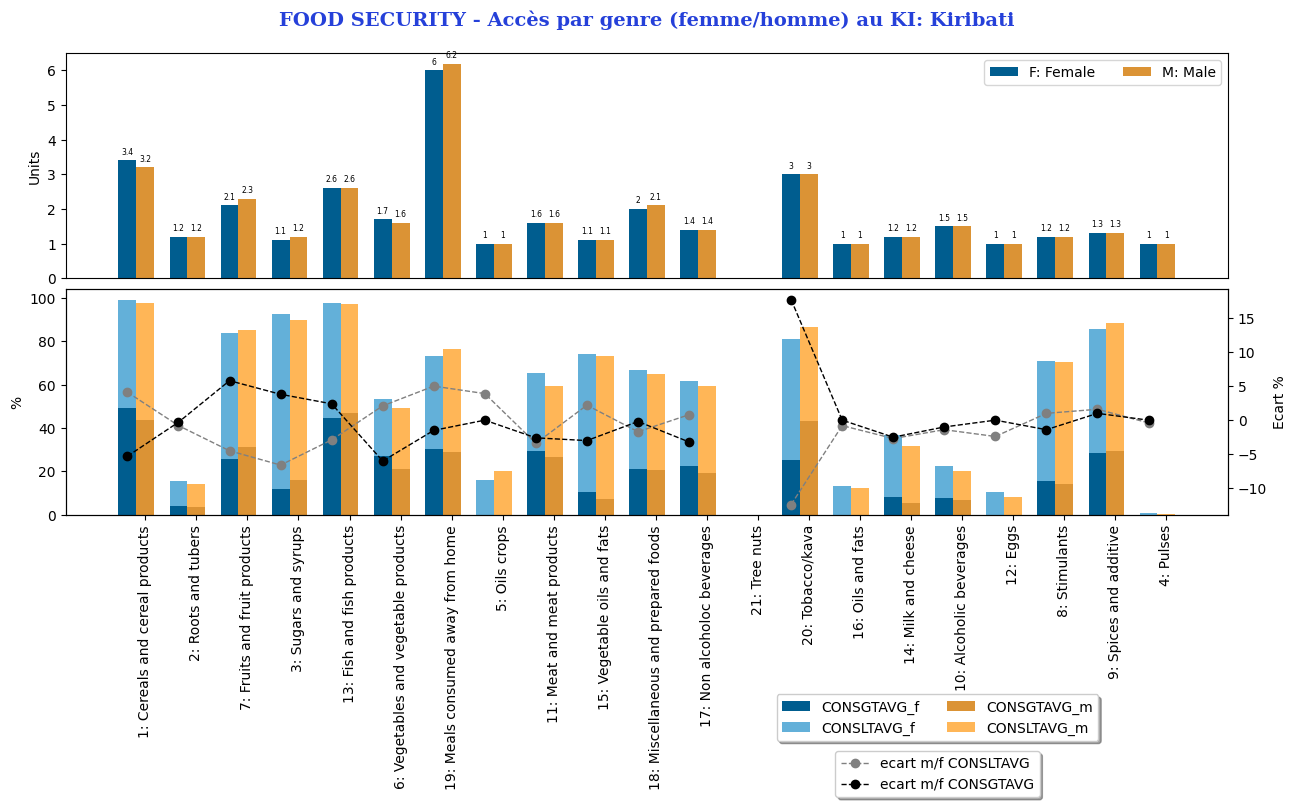

In [ ]:
## GRAPHIQUE
TITLE = "FOOD SECURITY - Accès par genre (femme/homme) au KI: Kiribati"
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,6)) # Nombre et disposition des zones de dessin
fig.subplots_adjust(hspace=0.05)
plt.xticks(rotation=90)
ax[0].set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 14},pad=20)


### 1 ####
categories = df_pivot_pays_total_AVGNPRDCONS.index.to_list()
genre = {
    'F: Female': df_pivot_pays_sex_AVGNPRDCONS['F: Female'].to_list(),
    'M: Male': df_pivot_pays_sex_AVGNPRDCONS['M: Male'].to_list(),
    # 'T: Total': df_pivot_pays_age_AVGNPRDCONS['_T: Total'].to_list(),
}

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0

bar_colors = ['#005D8F', '#DB9335']
i=0
for attribute, measurement in genre.items():
    offset = width * multiplier
    rects = ax[0].bar(x + offset, measurement, width, label=attribute, color=bar_colors[i])
    ax[0].bar_label(rects, padding=3, fontsize=5.5)
    multiplier += 1
    i+=1

# ax[0].set_ylabel('Nombre moyen de produits')
# ax[0].set_xticks(x + width, categories)
ax[0].legend(loc='upper right', ncols=3)
ax[0].set_xticks([])

### 2 ####
width = 0.35
categories = df_pivot_pays_sex_CONSLTAVG.index.to_list()
bar_colors_f = ['#005D8F', '#63B0D9', '#E15F5C']
bar_colors_m = ['#DB9335', '#FFB657', '#E15F5C']

# NO_ACCESS_f = [100 - (a_i + b_i) for a_i, b_i in zip(df_pivot_pays_age_CONSGTAVG['F: Female'].to_list(), df_pivot_pays_age_CONSLTAVG['F: Female'].to_list())]
pourcentages_f= {
    "CONSGTAVG_f": df_pivot_pays_sex_CONSGTAVG['F: Female'].to_list(),
    "CONSLTAVG_f": df_pivot_pays_sex_CONSLTAVG['F: Female'].to_list(),
    # "NO ACCESS_f": NO_ACCESS_f,
}

# NO_ACCESS_m = [100 - (a_i + b_i) for a_i, b_i in zip(df_pivot_pays_age_CONSGTAVG['M: Male'].to_list(), df_pivot_pays_age_CONSLTAVG['M: Male'].to_list())]
pourcentages_m= {
    "CONSGTAVG_m": df_pivot_pays_sex_CONSGTAVG['M: Male'].to_list(),
    "CONSLTAVG_m": df_pivot_pays_sex_CONSLTAVG['M: Male'].to_list(),
    # "NO ACCESS_m": NO_ACCESS_m,
}

x = np.arange(len(categories))
i=0
bottom_f = np.zeros(len(df_pivot_pays_sex_CONSGTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_f.items():
    p = ax[1].bar(x, pourcentage, width, label=boolean, bottom=bottom_f, color=bar_colors_f[i])
    bottom_f += pourcentage
    i += 1

j=0
bottom_m = np.zeros(len(df_pivot_pays_sex_CONSGTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_m.items():
    p = ax[1].bar(x+width, pourcentage, width, label=boolean, bottom=bottom_m, color=bar_colors_m[j])
    bottom_m += pourcentage
    j += 1

ax2 = ax[1].twinx()
ax2.plot(df_pivot_pays_sex_CONSLTAVG.index.values, df_pivot_pays_sex_CONSLTAVG['ECART'], 'grey',linestyle='--', marker='o',linewidth=1, label='ecart m/f CONSLTAVG')
ax2.plot(df_pivot_pays_sex_CONSGTAVG.index.values, df_pivot_pays_sex_CONSGTAVG['ECART'], 'black',linestyle='--', marker='o',linewidth=1, label='ecart m/f CONSGTAVG')

ax[0].set_ylabel('Units')
ax[1].set_ylabel('%')
ax2.set_ylabel('Ecart %', )

ax[1].set_xticks(x + width, categories)
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=10, rotation=90)
ax[1].legend(loc="center",bbox_to_anchor=(0,0,1.5,-1.8), ncol=2, fancybox=True, shadow=True)
ax2.legend(loc="center",bbox_to_anchor=(0,0,1.5,-2.3), ncol=1, fancybox=True, shadow=True)


In [ ]:
# Analyse n°4
pays_list = ['SB: Solomon Islands']
df_pays = df_net[df_net['REGION'].isin(pays_list)]
df_pays_sex = df_pays.loc[#(df_pays['GENRE'] == '_T: Total') & \
                            (df_pays['AGE'] == '_T: All ages') & \
                            (df_pays['URBANISATION'] == '_T: National') & \
                            (df_pays['POVERTY'] == '_T: Total') & \
                            (df_pays['FOOD_SECURITY'] == '_T: Total')
                           ]
df_pays_sex_AVGNPRDCONS = df_pays_sex[df_pays_sex['INDICATEUR'] == 'AVGNPRDCONS: Average number of products consumed by household by food group']
df_pays_sex_AVGNPRDCONS = df_pays_sex_AVGNPRDCONS.groupby(['GENRE','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_sex_AVGNPRDCONS= df_pays_sex_AVGNPRDCONS.pivot_table(columns='GENRE', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_sex_AVGNPRDCONS = df_pivot_pays_sex_AVGNPRDCONS.reindex(global_order)
# print(df_pivot_pays_age_AVGNPRDCONS)

df_pays_sex_CONSLTAVG = df_pays_sex[df_pays_sex['INDICATEUR'] == 'CONSLTAVG: Percentage of households who consumed less than the average number of products consumed in the group']
df_pays_sex_CONSLTAVG = df_pays_sex_CONSLTAVG.groupby(['GENRE','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_sex_CONSLTAVG= df_pays_sex_CONSLTAVG.pivot_table(columns='GENRE', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_sex_CONSLTAVG = df_pivot_pays_sex_CONSLTAVG.reindex(global_order)
df_pivot_pays_sex_CONSLTAVG['ECART']=df_pivot_pays_sex_CONSLTAVG['M: Male']-df_pivot_pays_sex_CONSLTAVG['F: Female']
# print(df_pivot_pays_age_CONSLTAVG)

df_pays_sex_CONSGTAVG = df_pays_sex[df_pays_sex['INDICATEUR'] == 'CONSGTAVG: Percentage of households who consumed more than the average number of products consumed in the group']
df_pays_sex_CONSGTAVG = df_pays_sex_CONSGTAVG.groupby(['GENRE','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_sex_CONSGTAVG= df_pays_sex_CONSGTAVG.pivot_table(columns='GENRE', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_sex_CONSGTAVG = df_pivot_pays_sex_CONSGTAVG.reindex(global_order)
df_pivot_pays_sex_CONSGTAVG['ECART']=df_pivot_pays_sex_CONSGTAVG['M: Male']-df_pivot_pays_sex_CONSGTAVG['F: Female']
# print(df_pivot_pays_age_CONSGTAVG)

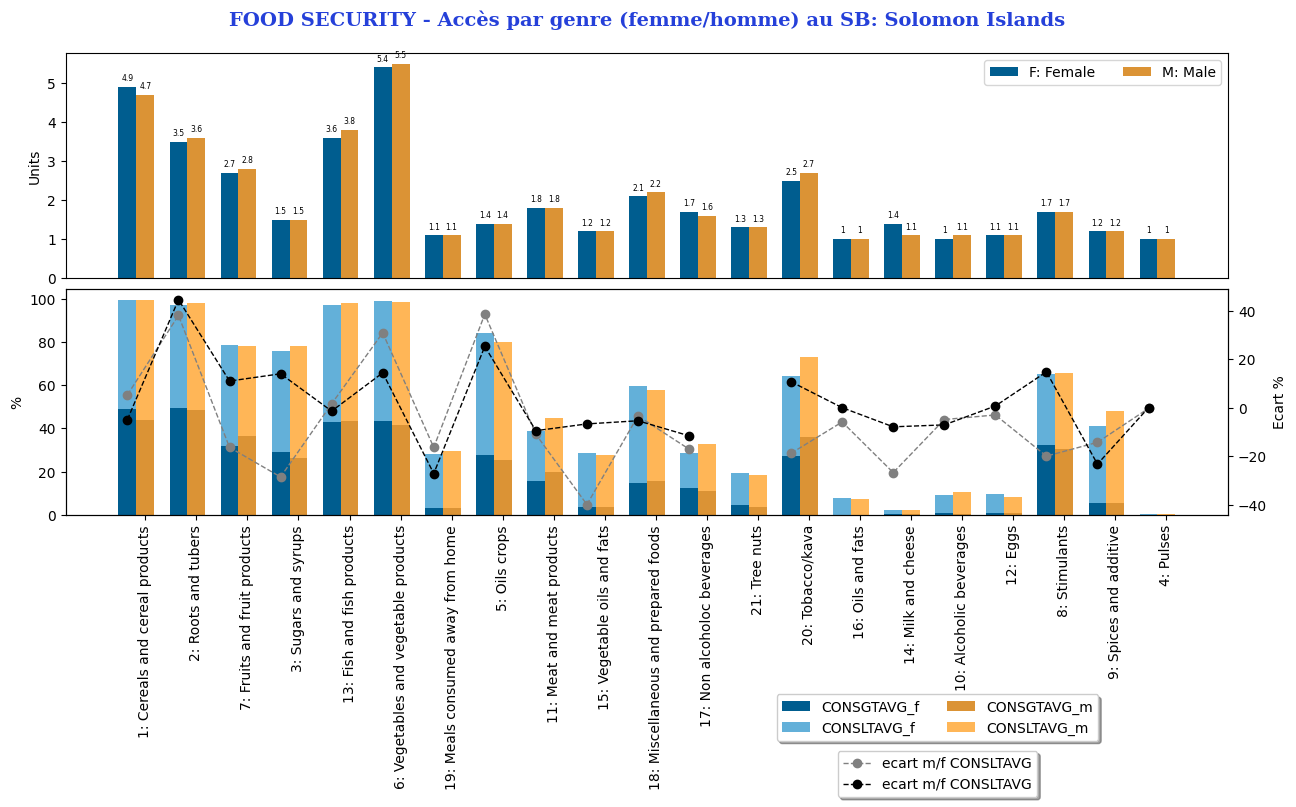

In [ ]:
## GRAPHIQUE
TITLE = "FOOD SECURITY - Accès par genre (femme/homme) au SB: Solomon Islands"
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,6)) # Nombre et disposition des zones de dessin
fig.subplots_adjust(hspace=0.05)
plt.xticks(rotation=90)
ax[0].set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 14},pad=20)


### 1 ####
categories = df_pivot_pays_total_AVGNPRDCONS.index.to_list()
genre = {
    'F: Female': df_pivot_pays_sex_AVGNPRDCONS['F: Female'].to_list(),
    'M: Male': df_pivot_pays_sex_AVGNPRDCONS['M: Male'].to_list(),
    # 'T: Total': df_pivot_pays_age_AVGNPRDCONS['_T: Total'].to_list(),
}

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0

bar_colors = ['#005D8F', '#DB9335']
i=0
for attribute, measurement in genre.items():
    offset = width * multiplier
    rects = ax[0].bar(x + offset, measurement, width, label=attribute, color=bar_colors[i])
    ax[0].bar_label(rects, padding=3, fontsize=5.5)
    multiplier += 1
    i+=1

# ax[0].set_ylabel('Nombre moyen de produits')
# ax[0].set_xticks(x + width, categories)
ax[0].legend(loc='upper right', ncols=3)
ax[0].set_xticks([])

### 2 ####
width = 0.35
categories = df_pivot_pays_sex_CONSLTAVG.index.to_list()
bar_colors_f = ['#005D8F', '#63B0D9', '#E15F5C']
bar_colors_m = ['#DB9335', '#FFB657', '#E15F5C']

# NO_ACCESS_f = [100 - (a_i + b_i) for a_i, b_i in zip(df_pivot_pays_age_CONSGTAVG['F: Female'].to_list(), df_pivot_pays_age_CONSLTAVG['F: Female'].to_list())]
pourcentages_f= {
    "CONSGTAVG_f": df_pivot_pays_sex_CONSGTAVG['F: Female'].to_list(),
    "CONSLTAVG_f": df_pivot_pays_sex_CONSLTAVG['F: Female'].to_list(),
    # "NO ACCESS_f": NO_ACCESS_f,
}

# NO_ACCESS_m = [100 - (a_i + b_i) for a_i, b_i in zip(df_pivot_pays_age_CONSGTAVG['M: Male'].to_list(), df_pivot_pays_age_CONSLTAVG['M: Male'].to_list())]
pourcentages_m= {
    "CONSGTAVG_m": df_pivot_pays_sex_CONSGTAVG['M: Male'].to_list(),
    "CONSLTAVG_m": df_pivot_pays_sex_CONSLTAVG['M: Male'].to_list(),
    # "NO ACCESS_m": NO_ACCESS_m,
}

x = np.arange(len(categories))
i=0
bottom_f = np.zeros(len(df_pivot_pays_sex_CONSGTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_f.items():
    p = ax[1].bar(x, pourcentage, width, label=boolean, bottom=bottom_f, color=bar_colors_f[i])
    bottom_f += pourcentage
    i += 1

j=0
bottom_m = np.zeros(len(df_pivot_pays_sex_CONSGTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_m.items():
    p = ax[1].bar(x+width, pourcentage, width, label=boolean, bottom=bottom_m, color=bar_colors_m[j])
    bottom_m += pourcentage
    j += 1

ax2 = ax[1].twinx()
ax2.plot(df_pivot_pays_age_CONSLTAVG.index.values, df_pivot_pays_sex_CONSLTAVG['ECART'], 'grey',linestyle='--', marker='o',linewidth=1, label='ecart m/f CONSLTAVG')
ax2.plot(df_pivot_pays_age_CONSGTAVG.index.values, df_pivot_pays_sex_CONSGTAVG['ECART'], 'black',linestyle='--', marker='o',linewidth=1, label='ecart m/f CONSLTAVG')

ax[0].set_ylabel('Units')
ax[1].set_ylabel('%')
ax2.set_ylabel('Ecart %', )

ax[1].set_xticks(x + width, categories)
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=10, rotation=90)
ax[1].legend(loc="center",bbox_to_anchor=(0,0,1.5,-1.8), ncol=2, fancybox=True, shadow=True)
ax2.legend(loc="center",bbox_to_anchor=(0,0,1.5,-2.3), ncol=1, fancybox=True, shadow=True)

In [ ]:
# Analyse n°4
pays_list = ['VU: Vanuatu']
df_pays = df_net[df_net['REGION'].isin(pays_list)]
df_pays_sex = df_pays.loc[#(df_pays['GENRE'] == '_T: Total') & \
                            (df_pays['age'] == '_T: All ages') & \
                            (df_pays['URBANISATION'] == '_T: National') & \
                            (df_pays['POVERTY'] == '_T: Total') & \
                            (df_pays['FOOD_SECURITY'] == '_T: Total')
                           ]
df_pays_sex_AVGNPRDCONS = df_pays_sex[df_pays_sex['INDICATEUR'] == 'AVGNPRDCONS: Average number of products consumed by household by food group']
df_pays_sex_AVGNPRDCONS = df_pays_sex_AVGNPRDCONS.groupby(['GENRE','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_sex_AVGNPRDCONS= df_pivot_pays_sex_AVGNPRDCONS.pivot_table(columns='GENRE', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_sex_AVGNPRDCONS = df_pivot_pays_sex_AVGNPRDCONS.reindex(global_order)
# print(df_pivot_pays_age_AVGNPRDCONS)

df_pays_sex_CONSLTAVG = df_pays_sex[df_pays_sex['INDICATEUR'] == 'CONSLTAVG: Percentage of households who consumed less than the average number of products consumed in the group']
df_pays_sex_CONSLTAVG = df_pays_sex_CONSLTAVG.groupby(['GENRE','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_sex_CONSLTAVG= df_pays_sex_CONSLTAVG.pivot_table(columns='GENRE', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_sex_CONSLTAVG = df_pivot_pays_sex_CONSLTAVG.reindex(global_order)
df_pivot_pays_sex_CONSLTAVG['ECART']=df_pivot_pays_sex_CONSLTAVG['M: Male']-df_pivot_pays_sex_CONSLTAVG['F: Female']
# print(df_pivot_pays_age_CONSLTAVG)

df_pays_sex_CONSGTAVG = df_pays_sex[df_pays_sex['INDICATEUR'] == 'CONSGTAVG: Percentage of households who consumed more than the average number of products consumed in the group']
df_pays_sex_CONSGTAVG = df_pays_sex_CONSGTAVG.groupby(['GENRE','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_sex_CONSGTAVG= df_pays_sex_CONSGTAVG.pivot_table(columns='GENRE', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_sex_CONSGTAVG = df_pivot_pays_sex_CONSGTAVG.reindex(global_order)
df_pivot_pays_sex_CONSGTAVG['ECART']=df_pivot_pays_sex_CONSGTAVG['M: Male']-df_pivot_pays_sex_CONSGTAVG['F: Female']
# print(df_pivot_pays_age_CONSGTAVG)

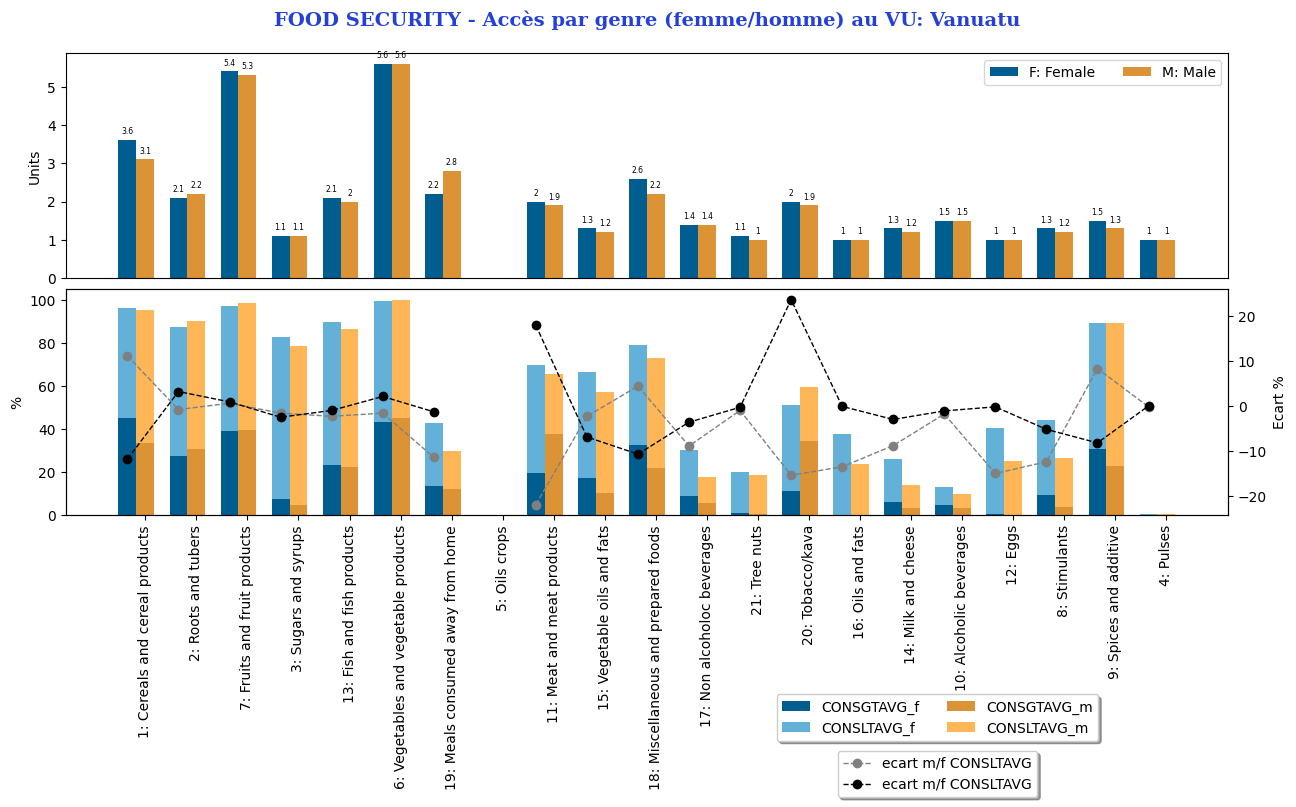

In [ ]:
## GRAPHIQUE
TITLE = "FOOD SECURITY - Accès par genre (femme/homme) au VU: Vanuatu"
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,6)) # Nombre et disposition des zones de dessin
fig.subplots_adjust(hspace=0.05)
plt.xticks(rotation=90)
ax[0].set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 14},pad=20)


### 1 ####
categories = df_pivot_pays_total_AVGNPRDCONS.index.to_list()
genre = {
    'F: Female': df_pivot_pays_sex_AVGNPRDCONS['F: Female'].to_list(),
    'M: Male': df_pivot_pays_sex_AVGNPRDCONS['M: Male'].to_list(),
    # 'T: Total': df_pivot_pays_age_AVGNPRDCONS['_T: Total'].to_list(),
}

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0

bar_colors = ['#005D8F', '#DB9335']
i=0
for attribute, measurement in genre.items():
    offset = width * multiplier
    rects = ax[0].bar(x + offset, measurement, width, label=attribute, color=bar_colors[i])
    ax[0].bar_label(rects, padding=3, fontsize=5.5)
    multiplier += 1
    i+=1

# ax[0].set_ylabel('Nombre moyen de produits')
# ax[0].set_xticks(x + width, categories)
ax[0].legend(loc='upper right', ncols=3)
ax[0].set_xticks([])

### 2 ####
width = 0.35
categories = df_pivot_pays_sex_CONSLTAVG.index.to_list()
bar_colors_f = ['#005D8F', '#63B0D9', '#E15F5C']
bar_colors_m = ['#DB9335', '#FFB657', '#E15F5C']

# NO_ACCESS_f = [100 - (a_i + b_i) for a_i, b_i in zip(df_pivot_pays_age_CONSGTAVG['F: Female'].to_list(), df_pivot_pays_age_CONSLTAVG['F: Female'].to_list())]
pourcentages_f= {
    "CONSGTAVG_f": df_pivot_pays_sex_CONSGTAVG['F: Female'].to_list(),
    "CONSLTAVG_f": df_pivot_pays_sex_CONSLTAVG['F: Female'].to_list(),
    # "NO ACCESS_f": NO_ACCESS_f,
}

# NO_ACCESS_m = [100 - (a_i + b_i) for a_i, b_i in zip(df_pivot_pays_age_CONSGTAVG['M: Male'].to_list(), df_pivot_pays_age_CONSLTAVG['M: Male'].to_list())]
pourcentages_m= {
    "CONSGTAVG_m": df_pivot_pays_sex_CONSGTAVG['M: Male'].to_list(),
    "CONSLTAVG_m": df_pivot_pays_sex_CONSLTAVG['M: Male'].to_list(),
    # "NO ACCESS_m": NO_ACCESS_m,
}

x = np.arange(len(categories))
i=0
bottom_f = np.zeros(len(df_pivot_pays_sex_CONSGTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_f.items():
    p = ax[1].bar(x, pourcentage, width, label=boolean, bottom=bottom_f, color=bar_colors_f[i])
    bottom_f += pourcentage
    i += 1

j=0
bottom_m = np.zeros(len(df_pivot_pays_sex_CONSGTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_m.items():
    p = ax[1].bar(x+width, pourcentage, width, label=boolean, bottom=bottom_m, color=bar_colors_m[j])
    bottom_m += pourcentage
    j += 1

ax2 = ax[1].twinx()
ax2.plot(df_pivot_pays_sex_CONSLTAVG.index.values, df_pivot_pays_sex_CONSLTAVG['ECART'], 'grey',linestyle='--', marker='o',linewidth=1, label='ecart m/f CONSLTAVG')
ax2.plot(df_pivot_pays_sex_CONSGTAVG.index.values, df_pivot_pays_sex_CONSGTAVG['ECART'], 'black',linestyle='--', marker='o',linewidth=1, label='ecart m/f CONSLTAVG')

ax[0].set_ylabel('Units')
ax[1].set_ylabel('%')
ax2.set_ylabel('Ecart %', )

ax[1].set_xticks(x + width, categories)
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=10, rotation=90)
ax[1].legend(loc="center",bbox_to_anchor=(0,0,1.5,-1.8), ncol=2, fancybox=True, shadow=True)
ax2.legend(loc="center",bbox_to_anchor=(0,0,1.5,-2.3), ncol=1, fancybox=True, shadow=True)

In [ ]:
# Analyse n°4
# pays_list = ['SB: Solomon Islands']
# pays_list = ['VU: Vanuatu']
# pays_list = ['KI: Kiribati']
# df_pays = df_net[df_net['REGION'].isin(pays_list)]
# df_pays_age = df_pays.loc[#(df_pays['GENRE'] == '_T: Total') & \
#                             (df_pays['age'] == '_T: All ages') & \
#                             (df_pays['URBANISATION'] == '_T: National') & \
#                             (df_pays['POVERTY'] == '_T: Total') & \
#                             (df_pays['FOOD_SECURITY'] == '_T: Total')
#                            ]
# df_pays_age_AVGNPRDCONS = df_pays_age[df_pays_age['INDICATEUR'] == 'AVGNPRDCONS: Average number of products consumed by household by food group']
# df_pays_age_AVGNPRDCONS = df_pays_age_AVGNPRDCONS.groupby(['GENRE','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
# df_pivot_pays_age_AVGNPRDCONS= df_pays_age_AVGNPRDCONS.pivot_table(columns='GENRE', index='FOOD_CATEGORY', values='Unit')
# df_pivot_pays_age_AVGNPRDCONS = df_pivot_pays_age_AVGNPRDCONS.reindex(global_order)
# # print(df_pivot_pays_age_AVGNPRDCONS)

# df_pays_age_CONSLTAVG = df_pays_age[df_pays_age['INDICATEUR'] == 'CONSLTAVG: Percentage of households who consumed less than the average number of products consumed in the group']
# df_pays_age_CONSLTAVG = df_pays_age_CONSLTAVG.groupby(['GENRE','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
# df_pivot_pays_age_CONSLTAVG= df_pays_age_CONSLTAVG.pivot_table(columns='GENRE', index='FOOD_CATEGORY', values='Unit')
# df_pivot_pays_age_CONSLTAVG = df_pivot_pays_age_CONSLTAVG.reindex(global_order)
# df_pivot_pays_age_CONSLTAVG['ECART']=df_pivot_pays_age_CONSLTAVG['M: Male']-df_pivot_pays_age_CONSLTAVG['F: Female']
# # print(df_pivot_pays_age_CONSLTAVG)

# df_pays_age_CONSGTAVG = df_pays_age[df_pays_age['INDICATEUR'] == 'CONSGTAVG: Percentage of households who consumed more than the average number of products consumed in the group']
# df_pays_age_CONSGTAVG = df_pays_age_CONSGTAVG.groupby(['GENRE','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
# df_pivot_pays_age_CONSGTAVG= df_pays_age_CONSGTAVG.pivot_table(columns='GENRE', index='FOOD_CATEGORY', values='Unit')
# df_pivot_pays_age_CONSGTAVG = df_pivot_pays_age_CONSGTAVG.reindex(global_order)
# df_pivot_pays_age_CONSGTAVG['ECART']=df_pivot_pays_age_CONSGTAVG['M: Male']-df_pivot_pays_age_CONSGTAVG['F: Female']
# # print(df_pivot_pays_age_CONSGTAVG)

KeyError: 'sex'